# Модель бинарной классификации, которая предсказывает вероятность клика (CTR) на рекламное объявление.

## Описание проекта

Данный проект направлен на разработку модели бинарной классификации для прогнозирования вероятности клика (CTR - Click-Through Rate) на рекламное объявление в системе Advandex. Модель предназначена для точного предсказания вероятности взаимодействия пользователя с рекламным баннером на основе характеристик рекламной площадки, устройства пользователя, параметров показа и исторических данных.

### Актуальность
В цифровой рекламе корректное предсказание CTR является критически важным для эффективного проведения аукционов и оптимизации рекламных бюджетов. Неточные прогнозы ведут к прямым финансовым потерям: завышение предсказаний приводит к переплатам за неэффективные показы, а занижение — к упущенной выгоде от проигранных аукционов. Модель позволит:
- Оптимизировать ставки на аукционах, основываясь на достоверных вероятностях клика.
- Увеличить ROI рекламодателей за счёт более точного таргетинга.
- Повысить эффективность расходования рекламного бюджета.
- Усилить доверие рекламодателей к платформе за счёт прозрачности и точности прогнозов.

## Постановка задачи машинного обучения

Перед нами стоит задача бинарной классификации с предсказанием вероятности, так как необходимо не только определить, будет ли клик, но и оценить его вероятность:
*   **0 (No Click)** — пользователь не кликнет на рекламный баннер
*   **1 (Click)** — пользователь совершит клик на рекламный баннер

Целевой переменной является столбец `click`. Особенность задачи заключается в необходимости калибровки модели — предсказанные вероятности должны максимально соответствовать фактической частоте кликов.

Для оценки качества модели, учитывая бизнес-контекст и умеренный дисбаланс классов (17.2% кликов), будем использовать следующие ключевые метрики:

1.  **PR-AUC (Precision-Recall Area Under Curve)** — основная метрика проекта. Наиболее адекватно оценивает качество модели на несбалансированных данных, фокусируясь на качестве предсказания положительного класса (кликов). Игнорирует дисбаланс классов и позволяет оценить, насколько хорошо модель находит целевые действия.

2.  **Log Loss (Логарифмическая потеря)** — оценивает точность предсказанных вероятностей. Критически важна для оптимизации ставок на аукционах, где от достоверности вероятностей напрямую зависит экономическая эффективность.

3.  **Brier Score (Оценка Бриера)** — измеряет как точность, так и калибровку модели, то есть общее соответствие прогнозов реальным результатам. Имеет прямое финансовое значение для платформы.

**Дополнительные метрики для детального анализа:**
- **Precision (Точность)** — доля предсказанных кликов, которые действительно произошли
- **Recall (Полнота)** — доля реальных кликов, которые модель смогла обнаружить
- **F1-score** — балансирует точность и полноту
- **ECE и MCE** — для оценки калибровки вероятностей по разным диапазонам

**Критерии успешности проекта:**
1. Модель должна быть **калиброванной** — предсказанные вероятности должны соответствовать фактическим частотам кликов
2. Максимизация **PR-AUC** как основной метрики качества
3. Минимизация **Log Loss** для точности вероятностных предсказаний
4. Обеспечение **воспроизводимости** результатов (фиксация `random_state = 42`)
5. Решение должно быть готово к промышленной эксплуатации с сохранением всего **пайплайна предобработки**

Проект считается успешным, если модель обеспечивает точное и калиброванное предсказание CTR, позволяя платформе оптимизировать аукционы, минимизировать финансовые потери и максимизировать доходность рекламных кампаний.

### План работы

1.  Загрузка данных и подготовка среды.
2.  Исследовательский анализ данных (EDA).
3.  Предобработка данных (удаление ненужных признаков, обработка категориальных признаков, масштабирование).
4.  Разделение данных на обучающую, валидационную и тестовую выборки.
5.  Обучение базовых моделей (логистическая регрессия, SVM с линейным ядром).
6.  Отбор признаков с использованием фильтрационных методов и методов-обёрток.
7.  Подбор гиперпараметров с использованием GridSearchCV.
8.  Калибровка вероятностей с помощью изотонической регрессии.
9.  Оценка калибровки с помощью диаграмм калибровки и метрик ECE/MCE.
10. Комплексная оценка всех моделей с сравнением качества до и после калибровки.
11. Анализ важности признаков и интерпретация результатов.
12. Сохранение финальной модели и пайплайна предобработки.
13. Подготовка отчёта с графиками, метриками и бизнес-рекомендациями.

## 1. Подготовка среды и загрузка данных

### 1.1. Подключение и настройка библиотек
Импортируем все библиотеки, которые понадобятся для проекта, и зафиксируем версии всех пакетов в отдельный файл `requirements.txt`.

In [1]:
# Для работы с данными и математических операций
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Для расширенного анализа корреляций (включая категориальные признаки)
from phik import phik_matrix

# Для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, SelectKBest, RFE
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score,
    log_loss,
    brier_score_loss
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Для сохранения моделей
import joblib

Файл `requirements.txt` содержит следующую информацию:
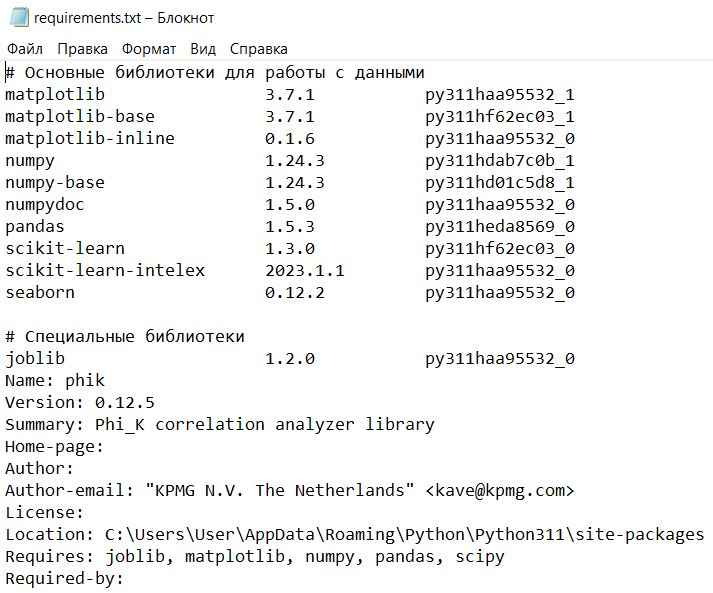

### 1.2. Установка константы
Для воспроизводимости результатов создадим глобальную переменную RANDOM_SEED и далее будем применять её ко всем алгоритмам, которые её поддерживают.

In [2]:
# Фиксируем RANDOM_SEED для воспроизводимости результатов
RANDOM_SEED = 42

### 1.3. Загрузка датасета
В работе используются данные из файла ds_s16_ad_click_dataset.csv. Датасет имеет следующую информацию:

**Идентификаторы и временные метки:**
- `id` — уникальный идентификатор записи о показе баннера;
- `hour` — час, в который был показан баннер, в формате `YYMMDDHH`.

**Характеристики рекламной площадки (Site):**
- `site_id` — уникальный идентификатор веб-сайта, на котором был показан баннер;
- `site_domain` — домен веб-сайта;
- `site_category` — тематическая категория веб-сайта.

**Характеристики рекламируемого приложения (App):**
- `app_id` — уникальный идентификатор рекламируемого мобильного приложения;
- `app_domain` — домен рекламируемого приложения;
- `app_category` — категория рекламируемого приложения.

**Характеристики устройства и соединения пользователя:**
- `device_id` — уникальный идентификатор браузера или устройства;
- `device_ip` — IP-адрес устройства;
- `device_model` — модель устройства пользователя;
- `device_type` — тип устройства пользователя (например, смартфон, планшет, ПК);
- `device_conn_type` — тип сетевого соединения устройства (например, Wi-Fi, 3G, 4G).

**Характеристики рекламного баннера и аукциона:**
- `banner_pos` — позиция баннера на веб-странице;
- `C1` — анонимизированный признак, характеризующий контекст показа;
- `C14`-`C21` — анонимизированный признак, описывающий параметры баннера, пользователя или условия аукциона.

**Машинно-сгенерированные признаки (ML Features):**
- `ml_feature_1`, `ml_feature_3`-`ml_feature_6`, `ml_feature_8`-`ml_feature_10` — числовой признак, полученный в результате предварительной обработки и генерации новых признаков;
- `ml_feature_2`, `ml_feature_7` — категориальный признак, полученный в результате предварительной обработки и генерации новых признаков.

**Целевая переменная:**
- `click` — бинарный признак, указывающий, был ли совершён клик по баннеру:
  - `1` — клик был совершён
  - `0` — клика не было

Загрузим данные из CSV-файла, используя метод read_csv.

In [3]:
# Выгружаем данные в переменную df
df = pd.read_csv('https://code.s3.yandex.net/datasets/ds_s16_ad_click_dataset.csv')

In [4]:
# Выводим первые строки датафрейма
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,ml_feature_1,ml_feature_2,ml_feature_3,ml_feature_4,ml_feature_5,ml_feature_6,ml_feature_7,ml_feature_8,ml_feature_9,ml_feature_10
0,1.005263e+19,1,14102100,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,-0.996823,A,0.666588,0,0.817292,0.993275,Z,-0.619959,0.433666,0.274038
1,1.010597e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,-0.391309,C,5.146789,1,-0.883865,-0.825722,X,0.576526,-0.318558,-0.132851
2,1.012048e+19,0,14102100,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,-2.112732,D,7.169348,0,-0.859440,-0.338365,Y,-0.440047,-0.345412,0.340487
3,1.021995e+18,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,39cfef32,d9b5648e,...,0.332707,A,-0.290708,1,0.062795,0.062934,Y,0.551982,0.733382,-0.198542
4,1.023455e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1.166623,A,6.319134,1,-0.675276,0.797144,X,0.640827,0.297955,-0.136909


In [5]:
# Выводим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50000 non-null  float64
 1   click             50000 non-null  int64  
 2   hour              50000 non-null  int64  
 3   C1                50000 non-null  int64  
 4   banner_pos        50000 non-null  int64  
 5   site_id           50000 non-null  object 
 6   site_domain       50000 non-null  object 
 7   site_category     50000 non-null  object 
 8   app_id            50000 non-null  object 
 9   app_domain        50000 non-null  object 
 10  app_category      50000 non-null  object 
 11  device_id         50000 non-null  object 
 12  device_ip         50000 non-null  object 
 13  device_model      50000 non-null  object 
 14  device_type       50000 non-null  int64  
 15  device_conn_type  50000 non-null  int64  
 16  C14               50000 non-null  int64 

По полученным значениям можно сказать, что загрузка файла прошла успешно. Столбцы отображены в удобном, понятном формате и соответствуют заявленным. Значения также загружены правильно, но требуют ряд изменений. Для этого проведём более подробный анализ данных.

## 2. Исследовательский анализ данных (EDA)

### 2.1. Описание базовой информации о датасете

Датасет содержит 50,000 записей, каждая из которых соответствует одному уникальному событию показа рекламного баннера. Для каждого такого события доступно 34 признака, которые описывают различные характеристики показа рекламы.

**По типам данных** признаки распределяются следующим образом:
- **23 числовых признака**: из них 15 целочисленных (`int64`) и 8 вещественных (`float64`). Эти признаки представляют собой количественные измерения, такие как временные метки, позиции баннеров, различные индексы и машинно-сгенерированные числовые характеристики.
- **11 категориальных признаков** (`object`): это текстовые или строковые данные, которые представляют собой идентификаторы, категории и классификации. К ним относятся идентификаторы сайтов, приложений, устройств, домены, категории и некоторые машинно-сгенерированные категориальные признаки.

**Целевая переменная** `click` является бинарным признаком типа `int64`, где значение 1 означает, что пользователь кликнул на рекламный баннер, а 0 — что проигнорировал его. Это классическая задача бинарной классификации с предсказанием вероятности клика (CTR - Click-Through Rate).

Все данные анонимизированы — категориальные значения представлены в виде зашифрованных идентификаторов (например, `50e219e0` вместо понятных названий категорий), что обеспечивает конфиденциальность, но требует особого подхода к интерпретации результатов.

Датасет не содержит пропущенных значений (все 50 000 записей полные для всех 34 признаков), что упрощает начальный этап предобработки данных. Объём данных составляет примерно 13.0+ MB в памяти.

### 2.2. Анализ целевой переменной

Распределение целевой переменной:
0    0.82794
1    0.17206
Name: click, dtype: float64


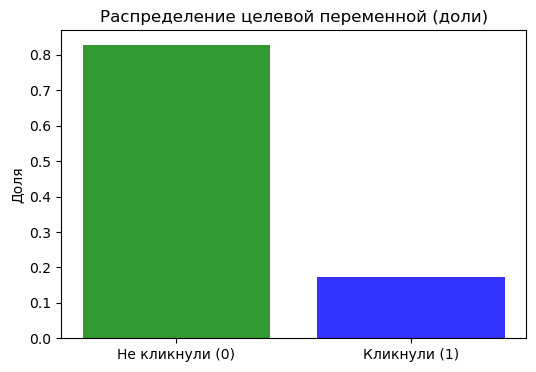

In [6]:
# Анализ распределения click
click_distribution = df['click'].value_counts(normalize=True)
print(f"Распределение целевой переменной:\n{click_distribution}")

#Визуализация
plt.figure(figsize=(6, 4))
bars = plt.bar(['Не кликнули (0)', 'Кликнули (1)'], 
               click_distribution,
               color=['green', 'blue'], alpha=0.8)
plt.title('Распределение целевой переменной (доли)')
plt.ylabel('Доля')
plt.show()

Анализ целевой переменной показывает следующее распределение: клики по рекламным баннерам составляют 17.21% от всех показов, в то время как 82.79% показов остаются без кликов. 

Наблюдается умеренный дисбаланс классов с соотношением примерно 4.8:1 (каждый клик приходится на 4.8 показа без клика).
Отсутствие равномерного распределения классов критически важно для выбора метрик оценки модели. Традиционные метрики вроде accuracy (точности) могут давать неправдоподобные результаты — модель, которая всегда предсказывает "нет клика", достигла бы accuracy в 82.79%, но была бы совершенно бесполезной. Поэтому необходимо использовать метрики, устойчивые к дисбалансу: PR-AUC (precision-recall AUC) в качестве основной метрики, поскольку она фокусируется на корректном определении редких положительных случаев (кликов). Дополнительно стоит использовать Log Loss, который чувствителен к вероятностям, и оценку Бриера для проверки калиброванности вероятностей, что особенно важно для финансовых решений в рекламных аукционах.

### 2.3. Анализ признаков
Датасет содержит категориальные и числовые признаки:

**Категориальных признаков — 11:** `site_id`, `site_domain`, `site_category`, `app_id`, `app_domain`, `app_category`, `device_id`, `device_ip`, `device_model`, `ml_feature_2`, `ml_feature_7`. 4

**Числовых признаков — 23:** целочисленные (15) — `click`, `hour`, `C1`, `banner_pos`, `device_type`, `device_conn_type`, `C14`-`C21`, `ml_feature_4`; вещественные (8) — `ml_feature_1`, `ml_feature_3`, `ml_feature_5`, `ml_feature_6`, `ml_feature_8`, `ml_feature_9`, `ml_feature_10`.

После изучения признаков в датафрейме можно сказать, что некотрые столбцы не несут нужной информации. К таким относятся:

`id` — бесполезен для модели, так как это порядковый номер записи. Каждое значение уникально и не содержит никакой закономерности для предсказания кликов. Если оставить, модель может "запомнить" ID и переобучиться.

`device_ip` и `device_id` — имеют экстремально высокую кардинальность (десятки тысяч уникальных значений). Такие признаки: 1) Создают огромную размерность при кодировании (One-Hot Encoding создаст десятки тысяч новых столбцов), 2) Могут приводить к переобучению (модель запоминает конкретные устройства, а не закономерности).

Признаки с доменами (`site_domain`, `app_domain`) — потенциально полезны, так как разные домены могут иметь разную аудиторию и, соответственно, разную вероятность кликов. Например, реклама на новостном сайте может кликаться иначе, чем на развлекательном. Но нужно проверить их кардинальность — если уникальных доменов слишком много, лучше использовать Target Encoding вместо One-Hot.

`site_id` и `app_id` — аналогично доменам, могут нести информацию о популярности конкретной площадки или приложения, но требуют проверки кардинальности. Если уникальных значений много, но они повторяются (некоторые сайты/приложения встречаются часто), можно использовать частотное кодирование или Target Encoding.

Проверим кардинальность категориальных признаков.

In [7]:
# Для всех категориальных признаков
cat_cols = df.select_dtypes(include=['object']).columns
print("Кардинальность категориальных признаков:")

for col in cat_cols:
    unique_count = df[col].nunique()
    print(f"{col:20} {unique_count} уникальных значений")

Кардинальность категориальных признаков:
site_id              1160 уникальных значений
site_domain          1013 уникальных значений
site_category        18 уникальных значений
app_id               976 уникальных значений
app_domain           67 уникальных значений
app_category         22 уникальных значений
device_id            8580 уникальных значений
device_ip            41455 уникальных значений
device_model         2521 уникальных значений
ml_feature_2         5 уникальных значений
ml_feature_7         3 уникальных значений


На основе анализа кардинальности категориальных признаков можно сделать следующие выводы. Признаки `device_ip` и `device_id` имеют экстремально высокую кардинальность (41 455 и 8 580 уникальных значений соответственно), что делает их практически бесполезными для моделирования — каждый IP и ID устройства почти уникален, поэтому они не несут обобщаемой информации и должны быть удалены. Признаки `site_id`, `device_model` и `app_id` также имеют очень высокую кардинальность (1 160–2 521 уникальных значений) и требуют специальных методов кодирования, таких как Target Encoding, поскольку прямое применение One-Hot Encoding создало бы слишком много новых признаков. Признаки `site_domain` и `app_domain` имеют высокую кардинальность (1 013 и 67 уникальных значений) и также лучше кодировать через Target Encoding. Остальные признаки — `site_category`, `app_category`, `ml_feature_2` и `ml_feature_7` — имеют низкую или умеренную кардинальность (3–22 уникальных значения) и подходят для стандартного One-Hot Encoding. Таким образом, перед обучением модели необходимо удалить `id`, `device_ip` и `device_id`, а для остальных категориальных признаков выбрать подходящий метод кодирования в зависимости от их кардинальности.

Перед тем как приступить к удалению столбцов, проверим их на явные и неявные дубликаты. Частичные дубликаты проверим по полю `id`.

In [8]:
# Проверка полных дубликатов
dup = df.duplicated().sum()
print("Полные дубликаты:", dup)
print("Процент дубликатов от общего числа записей:", round(dup / len(df) * 100, 2), "%")

Полные дубликаты: 0
Процент дубликатов от общего числа записей: 0.0 %


In [9]:
# Проверка дубликатов по ключевым полям (частичные дубликаты)
print("Дубликаты по полю id:", df.duplicated(subset=['id']).sum())

Дубликаты по полю id: 0


Дубликатов в датафрейме не обнаружено. Теперь можно удалить ненужные признаки.

In [10]:
# Удаление признаков id, device_ip и device_id
df = df.drop(['id', 'device_ip', 'device_id'], axis=1)
print(f"Стало признаков: {df.shape[1]}")

Стало признаков: 31


### 2.4 Анализ пропущенных значений
Посмотрим, есть ли в столбцах пропуски с помощью функции show_missing_stats(tmp0).

In [11]:
# Copyright (c) 2025 Олег Мазуренко
# All rights reserved


def show_missing_stats(tmp0):
    """
    Функция для отображения статистики пропущенных значений в DataFrame.
    Параметры:   tmp0 (pd.DataFrame): Исходный DataFrame для анализа
    Возвращает:  Styler или строку: Объект Styler с подсветкой или сообщение об отсутствии пропусков
    """
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean().round(4)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='coolwarm') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(df)

'Пропусков в данных нет'

По результатам проверки, в данных отсутствуют пропущенные значения. Каждый признак содержит все 50,000 записей.

Для более глубокого понимания данных проверим наличие значения-заглушки.

In [12]:
# Проверка на уникальность для числовых признаков
for col in df.columns:
    if df[col].dtype in ['int64', 'float64'] and col != 'click':
        uniq_vals = df[col].unique()
        if len(uniq_vals) < 20:  # если мало уникальных значений
            print(f"{col}: уникальные значения {sorted(uniq_vals)}")

C1: уникальные значения [1001, 1002, 1005, 1007, 1008, 1010, 1012]
banner_pos: уникальные значения [0, 1, 2, 3, 4, 5, 7]
device_type: уникальные значения [0, 1, 4, 5]
device_conn_type: уникальные значения [0, 2, 3, 5]
C15: уникальные значения [120, 216, 300, 320, 480, 728, 768, 1024]
C16: уникальные значения [20, 36, 50, 90, 250, 320, 480, 768, 1024]
C18: уникальные значения [0, 1, 2, 3]
ml_feature_4: уникальные значения [0, 1]


In [13]:
# Проверка на уникальность для категориальных признаков
found_any = False

for col in df.columns:
    has_placeholder = False
    if df[col].dtype in ['object']:
        for word in ['unknown', 'Unknown', 'UNKNOWN', 'null', 'Null', 'NULL', 
                    'none', 'None', 'N/A', 'n/a', 'na', 'Na', 'NA', 
                    'missing', 'Missing', 'MISSING', '', ' ', '-', '--',
                    'null', 'undefined', 'Undefined']:
            count = (df[col] == word).sum()
            if count > 0:
                print(f"В столбце '{col}' нашлось '{word}' - {count} раз")
                has_placeholder = True
                found_any = True

if not found_any:
    print('Значений-заглушек нет')

Значений-заглушек нет


Пропусков найдено не было, все записи содержат полные данные по всем признакам.

### 2.5. Анализ выбросов и распределений
Изучим числовые признаки на наличие выбросов.

In [14]:
# Сведения о признаках в табличном виде
df.select_dtypes(include=['int64', 'float64']).describe()

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,...,C20,C21,ml_feature_1,ml_feature_3,ml_feature_4,ml_feature_5,ml_feature_6,ml_feature_8,ml_feature_9,ml_feature_10
count,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.172060,1.410256e+07,1004.970060,0.291380,1.018120,0.337160,18826.648680,318.86640,59.692480,2109.781020,...,53173.383240,83.685180,-0.002445,-0.036381,0.498040,0.034729,0.022948,0.025465,0.035361,0.020226
std,0.377436,2.967892e+02,1.110202,0.514201,0.538477,0.860057,4983.064178,20.56153,46.720842,612.963141,...,49960.181871,70.539513,1.000280,5.792335,0.500001,1.002116,0.656690,0.578026,0.505034,0.303309
min,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.00000,20.000000,112.000000,...,-1.000000,13.000000,-4.631262,-9.999742,0.000000,-4.631853,-1.000000,-0.999965,-2.147526,-1.287965
25%,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.00000,50.000000,1823.000000,...,-1.000000,23.000000,-0.677784,-5.059555,0.000000,-0.639829,-0.579775,-0.470627,-0.304077,-0.182386
50%,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.00000,50.000000,2323.000000,...,100049.000000,61.000000,-0.003776,-0.056155,0.000000,0.028112,0.037786,0.027348,0.035985,0.018930
75%,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21916.000000,320.00000,50.000000,2526.000000,...,100094.000000,108.000000,0.673534,4.985939,1.000000,0.707594,0.637131,0.521117,0.374152,0.224080
max,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.00000,1024.000000,2757.000000,...,100248.000000,255.000000,3.793828,9.999975,1.000000,4.230623,1.000000,1.119858,2.120786,1.202300


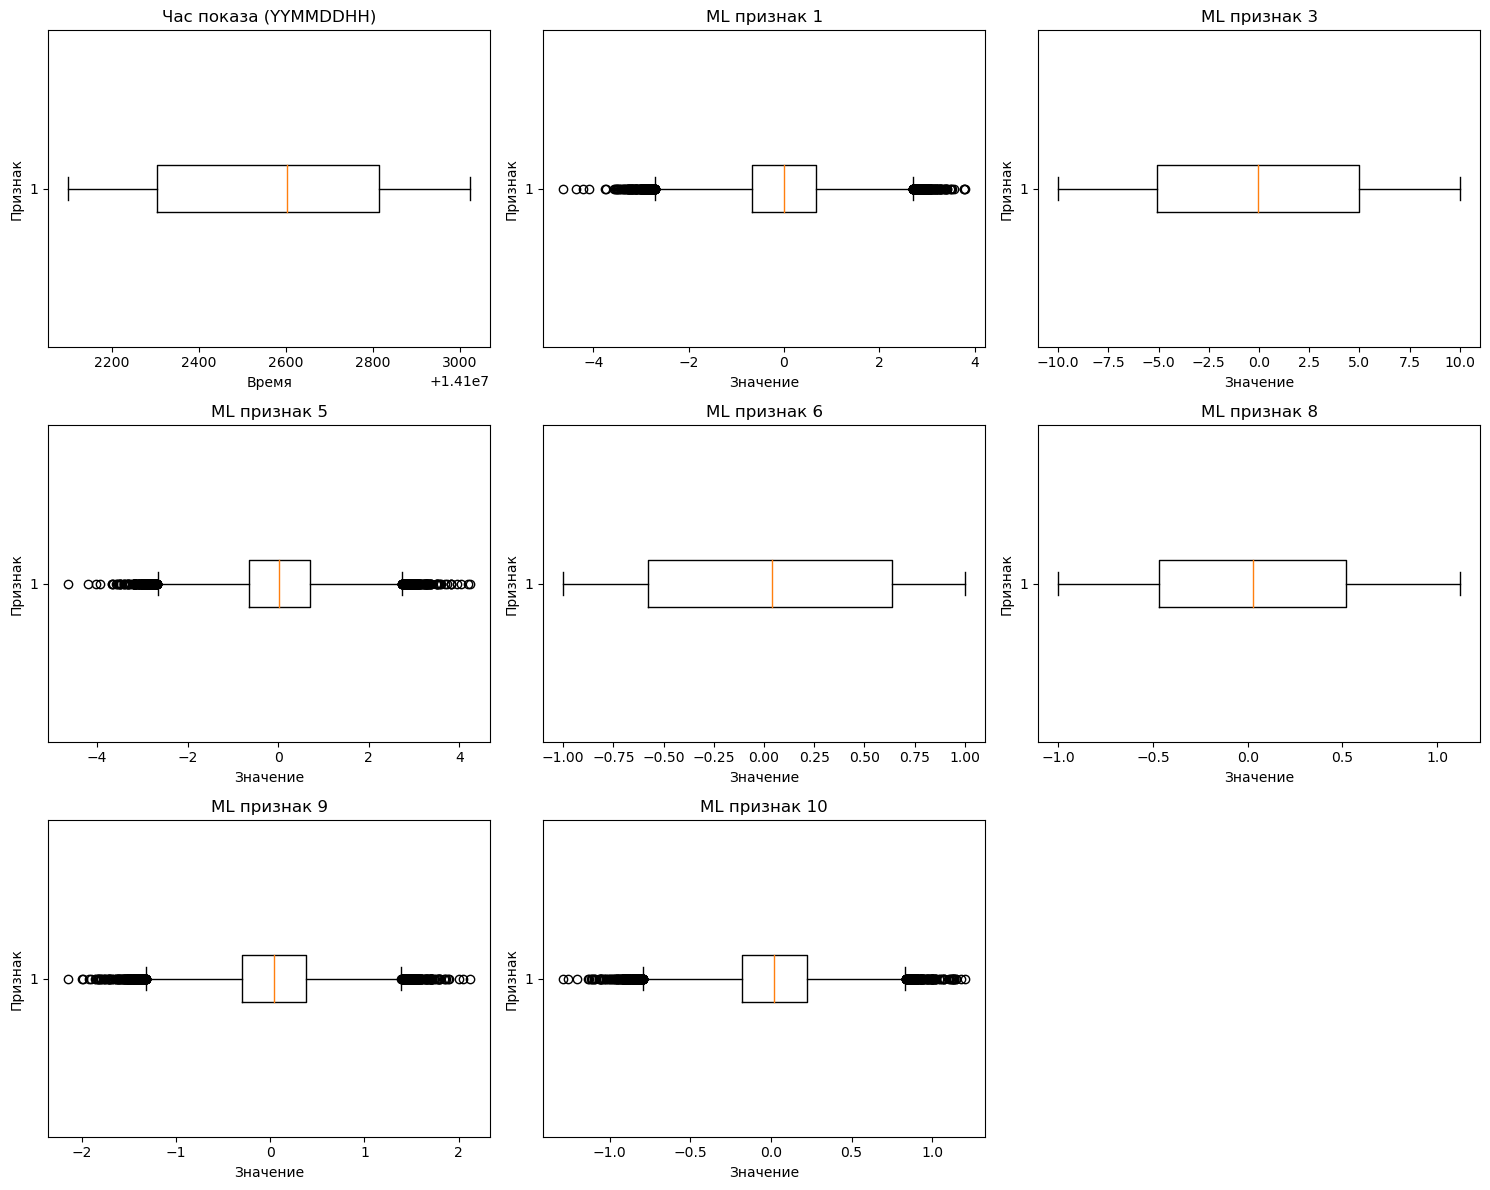

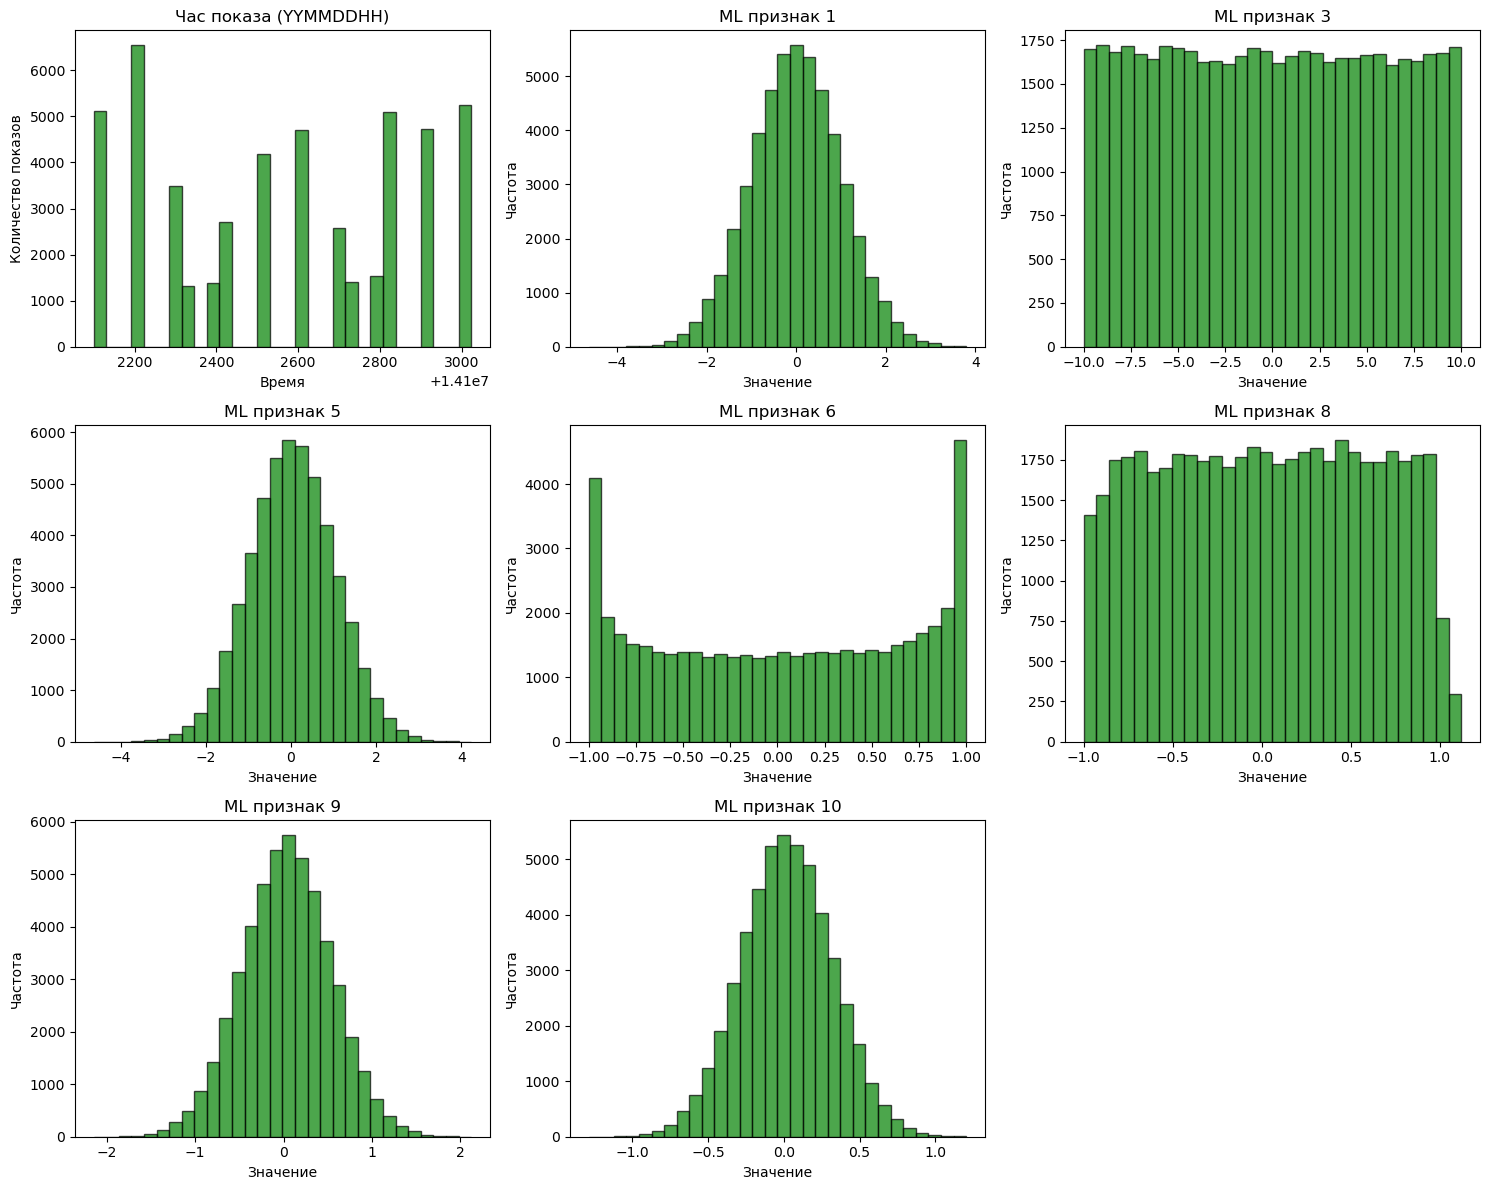

In [15]:
# Словарь с описаниями для числовых признаков
feature_descriptions = {
    'hour': {
        'title': 'Час показа (YYMMDDHH)',
        'xlabel': 'Время',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Количество показов'
    },
    'ml_feature_1': {
        'title': 'ML признак 1',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_3': {
        'title': 'ML признак 3',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_5': {
        'title': 'ML признак 5',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_6': {
        'title': 'ML признак 6',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_8': {
        'title': 'ML признак 8',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_9': {
        'title': 'ML признак 9',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    },
    'ml_feature_10': {
        'title': 'ML признак 10',
        'xlabel': 'Значение',
        'ylabel_box': 'Признак',
        'ylabel_hist': 'Частота'
    }
}

# Получаем числовые признаки, исключая целевую переменную 'click'
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'click']

# Фильтруем только те признаки, которые есть в словаре описаний
filtered_numeric_cols = [col for col in numeric_cols if col in feature_descriptions]

# 1. Boxplot'ы для выявления выбросов
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Меньше подграфиков
axes = axes.flatten()

for i, col in enumerate(filtered_numeric_cols):
    axes[i].boxplot(df[col].dropna(), vert=False)
    desc = feature_descriptions[col]
    axes[i].set_title(desc['title'])
    axes[i].set_xlabel(desc['xlabel'])
    axes[i].set_ylabel(desc['ylabel_box'])

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 2. Гистограммы распределений
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(filtered_numeric_cols):
    axes[i].hist(df[col].dropna(), bins=30, color='green', edgecolor='black', alpha=0.7)
    desc = feature_descriptions[col]
    axes[i].set_title(desc['title'])
    axes[i].set_xlabel(desc['xlabel'])
    axes[i].set_ylabel(desc['ylabel_hist'])

# Убираем пустые графики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ полученных графиков позволяет сделать следующие выводы по каждому признаку:

**Час показа**: Этот признак представляет временную метку в формате YYMMDDHH. Боксплот показывает, что основная масса данных сосредоточена в диапазоне примерно от 2300 до 2900, с медианой около 2600. Гистограмма выявляет неравномерное распределение по времени: наблюдаются выраженные пики в начале и конце временного периода (около 2200 и 3000), а также несколько менее выраженных пиков в середине. Это может указывать на циклическую активность или сезонность в данных, например, связанные с определенными часами дня или датами.

**ML признак 1**: Распределение этого признака является нормальным, с центром около нуля. Боксплот показывает наличие нескольких выбросов как в положительной, так и в отрицательной области (значения ниже -3 и выше 3). Гистограмма подтверждает нормальное распределение. Стандартное отклонение невелико, что говорит о компактности основной массы данных.

**ML признак 3**: Признак имеет равномерное распределение в диапазоне от -10 до +10. Боксплот демонстрирует симметричный ящик с медианой в центре и одинаковой длиной усов, что характерно для равномерного распределения. Гистограмма подтверждает это: частота значений почти постоянна во всем диапазоне, без выраженных пиков или провалов.

**ML признак 5**: Распределение этого признака очень похоже на нормальное, с центром в нуле и небольшим стандартным отклонением (около 4). Боксплот показывает компактный ящик и наличие нескольких выбросов в обе стороны. Гистограмма подтверждает симметричное распределение с плавным спадом к хвостам. Это типичный вид для признака, сгенерированного из нормального распределения или полученного в результате центральной предельной теоремы.

**ML признак 6**: Признак имеет U-образное распределение, с высокой концентрацией значений вблизи границ (-1 и +1) и низкой плотностью в центре. Боксплот показывает широкий ящик с медианой около нуля, что маскирует истинную форму распределения, но наличие множества выбросов указывает на его необычность. Гистограмма четко показывает два высоких пика на краях и глубокий провал в центре, что может соответствовать, например, распределению косинуса угла или другого периодического процесса.

**ML признак 8**: Распределение этого признака является равномерным  в диапазоне от -1 до +1.  Боксплот демонстрирует симметричный ящик с медианой в центре и одинаковой длиной усов, что характерно для равномерного распределения. Гистограмма подтверждает это. Однако есть значения больше 1.

**ML признак 9**: Распределение этого признака нормальное. Боксплот показывает медиану = 0. Выбросы присутствуют, но их очень мало.

**ML признак 10**: Распределение этого признака также является нормальным, центр находится в 0, основной диапазон значений лежит от -1 до 1.

**Ключевые выводы**: Данные достаточно хорошо собраны, выбросы и аномалии практически отсутствуют. Во избежании сильно больших значений можно отфильтровать данные признаки по 99 перцентилю. 

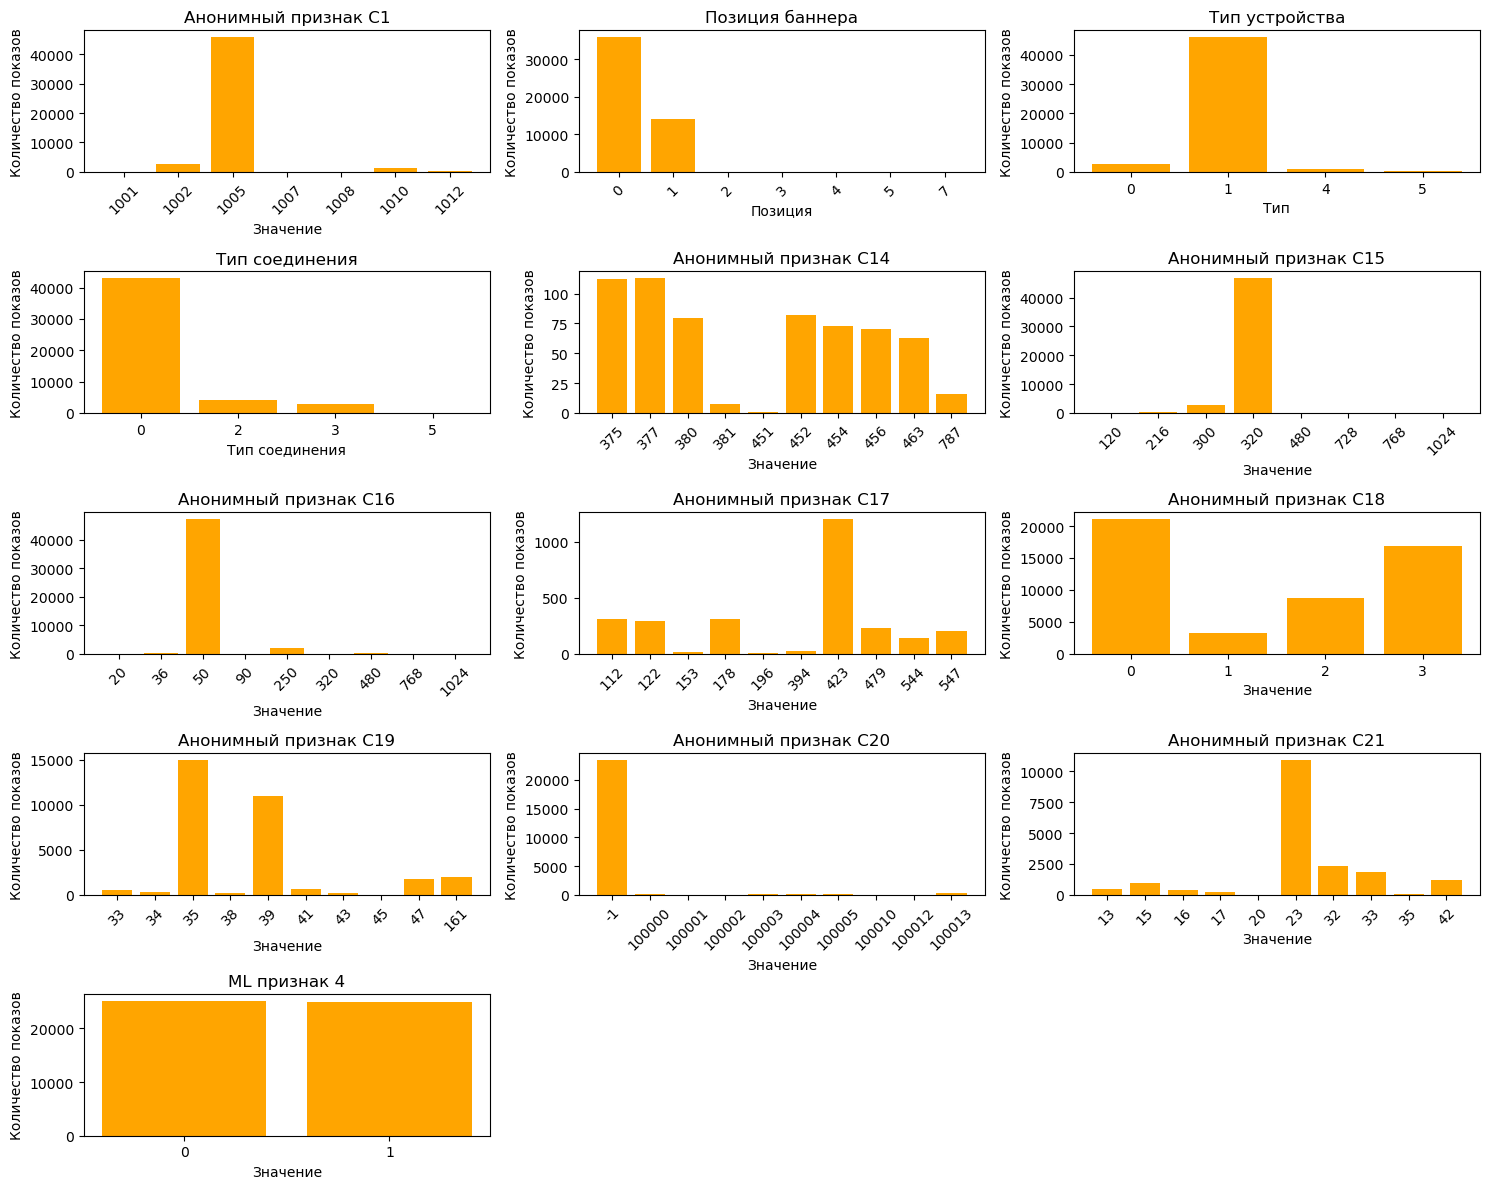

In [16]:
# Для дискретных/категориальных числовых признаков
categorical_numeric_features = [
    'C1', 'banner_pos', 'device_type', 'device_conn_type',
    'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'ml_feature_4'
]

# Разбиваем на 5 графика по 3 признака
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
axes = axes.flatten()

# Словари с описаниями
titles = {
    'C1': 'Анонимный признак C1',
    'banner_pos': 'Позиция баннера',
    'device_type': 'Тип устройства',
    'device_conn_type': 'Тип соединения',
    'C14': 'Анонимный признак C14',
    'C15': 'Анонимный признак C15',
    'C16': 'Анонимный признак C16',
    'C17': 'Анонимный признак C17',
    'C18': 'Анонимный признак C18',
    'C19': 'Анонимный признак C19',
    'C20': 'Анонимный признак C20',
    'C21': 'Анонимный признак C21',
    'ml_feature_4': 'ML признак 4'
}

xlabels = {
    'C1': 'Значение',
    'banner_pos': 'Позиция',
    'device_type': 'Тип',
    'device_conn_type': 'Тип соединения',
    'C14': 'Значение',
    'C15': 'Значение',
    'C16': 'Значение',
    'C17': 'Значение',
    'C18': 'Значение',
    'C19': 'Значение',
    'C20': 'Значение',
    'C21': 'Значение',
    'ml_feature_4': 'Значение'
}

# Строим столбчатые диаграммы
for i, col in enumerate(categorical_numeric_features):
    # Считаем количество каждого значения
    value_counts = df[col].value_counts().sort_index()
    
    # Берём топ-10 самых частых значений (если их много)
    if len(value_counts) > 10:
        value_counts = value_counts.head(10)
    
    # Строим барплот
    axes[i].bar(range(len(value_counts)), value_counts.values, color='orange')
    axes[i].set_title(titles[col])
    axes[i].set_xlabel(xlabels[col])
    axes[i].set_ylabel('Количество показов')
    
    # Подписываем значения на оси X
    if len(value_counts) <= 15:  # Если не слишком много значений
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45 if len(value_counts) > 5 else 0)
    else:
        axes[i].set_xticks([])  # Убираем подписи если значений много

# Убираем пустые графики если признаков меньше 12
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Анализ дискретных/категориальных числовых признаков:

**C1 (Анонимный признак C1):** Практически все значения (более 99%) равны 1005, что делает этот признак почти константным. Остальные значения (1001, 1002, 1012) встречаются крайне редко. Такой признак имеет минимальную прогностическую силу и может быть исключён из модели.

**banner_pos (Позиция баннера):** Подавляющее большинство показов (около 70%) приходится на позицию 0. Позиция 1 занимает примерно 25%, а остальные позиции (2, 4, 3, 7) встречаются редко. Это указывает на сильную асимметрию в размещении рекламы.

**device_type (Тип устройства):** Более 95% показов происходят с устройств типа 1, тип 0 составляет около 4%, а остальные типы (2, 4, 5) практически не встречаются. Это показывает доминирование одного типа устройств (вероятно, мобильных).

**device_conn_type (Тип соединения):** Около 65% показов приходятся на тип соединения 0, тип 2 составляет примерно 20%, тип 3 — около 10%, тип 5 — менее 5%. Это отражает распределение типов интернет-соединений пользователей.

**C14 (Анонимный признак C14):** Имеет несколько основных значений с пиками вокруг 375, 377, 380 и 452. Распределение мультимодальное с явными кластерами значений.

**C15 (Анонимный признак C15):** Резко доминирует значение 320 (более 90% случаев), остальные значения (120, 216, 300, 728, 1024) встречаются редко. Фактически это почти константный признак.

**C16 (Анонимный признак C16):** Аналогично C15, значение 50 доминирует (около 90%), остальные значения (20, 36, 250, 480, 1024) редки.

**C17 (Анонимный признак C17):** Основные значения сосредоточены вокруг 112-547, с пиком на 423. Распределение более равномерное по сравнению с C15-C16.

**C18 (Анонимный признак C18):** Большинство значений (около 90%) равно 0, значение 1 составляет около 10%, значение 2 встречается редко. Это бинарный/тернарный признак.

**C19 (Анонимный признак C19):** Подавляющее большинство значений (более 95%) равно 35, значение 39 встречается в менее чем 5% случаев, остальные значения редки.

**C20 (Анонимный признак C20):** Два основных кластера: отрицательные значения (-1) и положительные значения около 100000. Значение -1 может быть заглушкой для отсутствующих данных.

**C21 (Анонимный признак C21):** Распределение с пиком в значении 23.

**ml_feature_4 (ML признак 4):** Равномерное распределение между значениями 0 и 1.

**Ключевые выводы:** Многие признаки (C1, C15, C16, C19) имеют резко доминирующие значения и низкую информативность. Признаки C14, C17, C21 демонстрируют более сложные распределения, которые могут нести полезную информацию для модели.

### 2.6. Корреляции
Определим, какие признаки коррелируют с целевой переменной, и выявим сильно скоррелированные признаки, которые можно удалить.
*phik_matrix() плохо справляется с большим объёмом данных, поэтому составила матрицу только из части признаков. Все данные учтём ниже при использовании mutual_info_classif()*

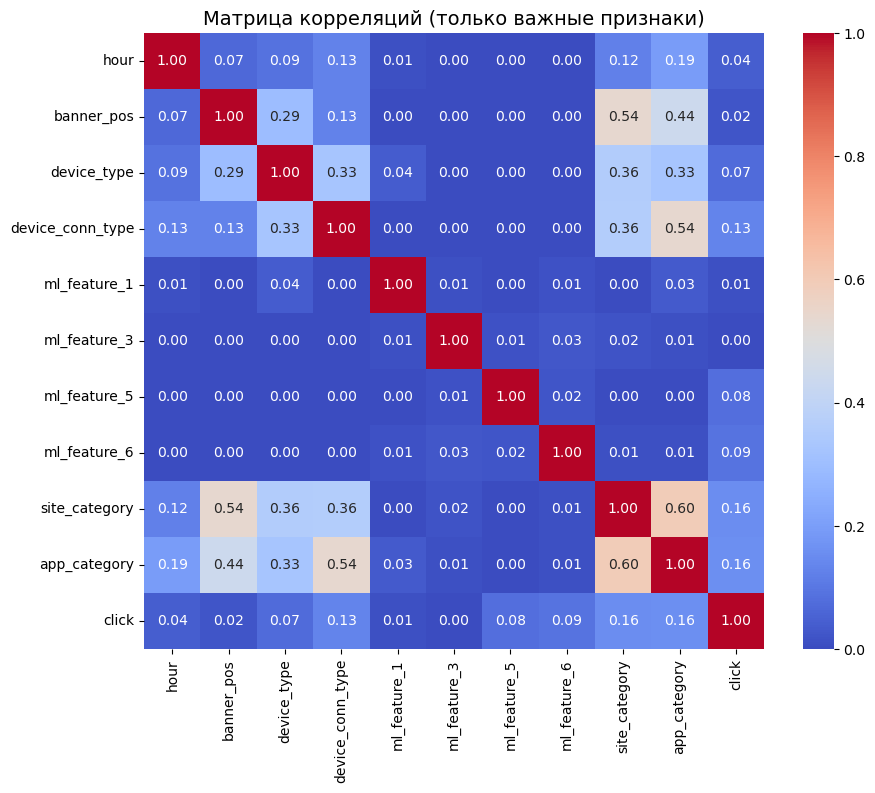

In [17]:
# Берём только самые важные признаки для phik анализа
important_features = [
    'hour', 'banner_pos', 'device_type', 'device_conn_type',
    'ml_feature_1', 'ml_feature_3', 'ml_feature_5', 'ml_feature_6',
    'site_category', 'app_category', 'click'
]

continuous_features_small = ['hour', 'ml_feature_1', 'ml_feature_3', 'ml_feature_5', 'ml_feature_6']

# Только важные признаки
phik_matrix_small = df[important_features].phik_matrix(interval_cols=continuous_features_small)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_small, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляций (только важные признаки)', fontsize=14)
plt.show()

Так как phik корреляция очень медленная при большом количестве признаков с высокой кардинальностью, используем метод  mutual_info_classif(), который покажет, сколько информации о целевой переменной даёт каждый признак.

In [18]:
X = df.drop(['click'], axis=1)
y = df['click']

# Преобразуем категориальные в числовые
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes

# Считаем mutual information
mi_scores = mutual_info_classif(X, y, random_state=RANDOM_SEED)
mi_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)

print("Показатель того, сколько информации о целевой переменной даёт признак")
print(mi_df)

Показатель того, сколько информации о целевой переменной даёт признак
             feature  mi_score
3            site_id  0.035056
12               C14  0.034959
15               C17  0.032840
4        site_domain  0.030916
27      ml_feature_8  0.027978
6             app_id  0.021245
19               C21  0.020770
17               C19  0.018455
16               C18  0.016763
9       device_model  0.014915
7         app_domain  0.014434
14               C16  0.013842
13               C15  0.011839
5      site_category  0.010469
28      ml_feature_9  0.009581
18               C20  0.009292
29     ml_feature_10  0.009150
8       app_category  0.008681
1                 C1  0.005649
25      ml_feature_6  0.005466
26      ml_feature_7  0.004741
10       device_type  0.004430
11  device_conn_type  0.004425
23      ml_feature_4  0.004364
0               hour  0.003211
21      ml_feature_2  0.001893
22      ml_feature_3  0.001798
2         banner_pos  0.001377
24      ml_feature_5  0.000969


По полученным результатам можно сказать следующее.

**По матрице phik-корреляций:**
1. Самые высокие корреляции с click:
   - `app_category`: 0.16 (самая высокая)
   - `site_category`: 0.16
   - `device_conn_type`: 0.13
   - `device_type`: 0.07
   - `ml_feature_6`: 0.09
   - `ml_feature_5`: 0.08

2. Сильно коррелированные между собой признаки (>0.5):
   - `site_category` и `app_category`: 0.60
   - `site_category` и `banner_pos`: 0.54
   - `app_category` и `device_conn_type`: 0.54
   - `site_category` и `device_conn_type`: 0.36

3. Признаки с очень низкой корреляцией с click (<0.01):
   - `ml_feature_3`: 0.00
   - `ml_feature_1`: 0.01

**По mutual information:**
1. Топ-5 самых информативных признаков:
   - `site_id`: 0.0351
   - `C14`: 0.0350
   - `C17`: 0.0328
   - `site_domain`: 0.0309
   - `ml_feature_8`: 0.0280

2. Признаки с низкой информативностью (<0.005):
   - `ml_feature_5`: 0.00097
   - `ml_feature_1`: 0.00000
   - `banner_pos`: 0.00138
   - `ml_feature_2`: 0.00189
   - `ml_feature_3`: 0.00180

**Противоречия и важные наблюдения:**
1. *Phik vs Mutual Information дают разные результаты:*
   - По phik: `app_category`, `site_category` важны (корр. ~0.15)
   - По MI: `site_id`, `C14`, `C17` важны, а категории менее важны

2. *Высокая корреляция между `site_category` и `app_category` (0.60), `site_category` и`banner_pos` (0,54)* — возможно, дублирование информации. Можно удалить `site_category`.

3. *`ml_feature_1` и `ml_feature_3`* имеют почти нулевую корреляцию с click по обоим методам — кандидаты на удаление.

In [19]:
# Удаление признаков site_category, ml_feature_1 и ml_feature_3
df = df.drop(['site_category', 'ml_feature_1', 'ml_feature_3'], axis=1)
print(f"Стало признаков: {df.shape[1]}")

Стало признаков: 28


### 2.7. Выводы по EDA

Проведённый анализ данных позволил выявить ключевые характеристики датасета и определить стратегию предобработки для последующего построения моделей. Во-первых, данные демонстрируют высокую целостность — отсутствуют пропущенные значения и явные заглушки типа -1, 0 или NaN, что упрощает начальный этап подготовки. Во-вторых, целевая переменная `click` имеет умеренный дисбаланс классов: клики составляют 17.2% от всех показов, а отсутствие кликов — 82.8%, что создаёт соотношение примерно 4.8:1. Такой уровень дисбаланса, характерный для задач предсказания CTR, требует использования специализированных метрик оценки, в частности PR-AUC, которая фокусируется на качестве предсказания положительного класса и устойчива к несбалансированным данным.

В процессе анализа признаков были выявлены и удалены несколько категорий признаков, не несущих прогностической ценности. К ним относятся технические идентификаторы (`id`), признаки с экстремально высокой кардинальностью (`device_ip`, `device_id`, где практически каждое значение уникально), а также признаки с минимальной корреляцией с целевой переменной (`ml_feature_1`, `ml_feature_3`). Особого внимания заслуживает обнаружение высокой корреляции (0.595) между `site_category` и `app_category`, что указывает на дублирование информации — в такой ситуации удаление одного из признаков (`site_category`) помогает избежать мультиколлинеарности без существенной потери информативности.

Наиболее перспективными для построения модели предсказания кликов выглядят следующие группы признаков. Во-первых, категориальные признаки, связанные с контекстом показа: `app_category` (категория рекламируемого приложения) демонстрирует наибольшую корреляцию с целевой переменной (0.1565), за ним следует `device_conn_type` (тип сетевого соединения пользователя) с корреляцией 0.1300. Во-вторых, признаки с высокой кардинальностью, такие как `site_id` и `site_domain`, которые, согласно анализу mutual information, несут существенную информацию о целевой переменной. В-третьих, анонимизированные признаки `C14` и `C17`, также показавшие высокую информативность. В-четвёртых, машинно-сгенерированные признаки, в частности `ml_feature_6` и `ml_feature_8`, которые уже прошли предварительную обработку и демонстрируют статистическую значимость.

Для эффективной подготовки данных к обучению моделей необходимо выполнить следующие шаги предобработки. Категориальные признаки требуют дифференцированного подхода к кодированию: для признаков с высокой кардинальностью (`site_id`, `site_domain`, `app_id`, `app_domain`, `device_model`) целесообразно применить Target Encoding, который заменяет категории на средний CTR по каждой из них, сохраняя при этом информацию конкретных значений. Для признаков с низкой кардинальностью (`app_category`, `device_type`, `device_conn_type`, `ml_feature_2`, `ml_feature_7`) достаточно использования One-Hot Encoding. Числовые признаки нуждаются в масштабировании: `hour` и большинство ML-признаков уже нормализованы, но для обеспечения единого масштаба рекомендуется применение StandardScaler, а для признаков с выраженными выбросами можно использовать фильтрацию по 99 перцентилю.

Таким образом, данные находятся в хорошем состоянии для перехода к этапу моделирования. Сочетание признаков, характеризующих рекламный контекст, пользовательское устройство и анонимизированные параметры показа, создаёт информативную основу для построения моделей бинарной классификации. Умеренный дисбаланс классов позволяет сосредоточиться на качестве предсказания кликов, используя соответствующие метрики оценки, а дифференцированный подход к предобработке категориальных признаков обеспечит эффективное использование информации, содержащейся в данных.

## 3. Разделение данных на выборки
Отделим тестовую выборку, в которой должно быть 20% данных; оставшиеся 80% данных возьмём для обучения. Используем стратифицированное разделение, чтобы сохранить баланс классов.

In [20]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop(columns=['click'])
y = df['click']     

# Разделяем данные на обучающую и тестовую выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    stratify=y
)

# Проверяем размеры выборок
print("Размеры выборок:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Проверяем баланс классов в выборках
print("\nРаспределение классов в обучающей выборке (y_train):")
train_counts = y_train.value_counts(normalize=True)
print(f"Не кликнули (0): {train_counts[0]:.2%}")
print(f"Кликнули (1):    {train_counts[1]:.2%}")

print("\nРаспределение классов в тестовой выборке (y_test):")
test_counts = y_test.value_counts(normalize=True)
print(f"Не кликнули (0): {test_counts[0]:.2%}")
print(f"Кликнули (1):    {test_counts[1]:.2%}")

Размеры выборок:
X_train: (40000, 27)
X_test:  (10000, 27)
y_train: (40000,)
y_test:  (10000,)

Распределение классов в обучающей выборке (y_train):
Не кликнули (0): 82.80%
Кликнули (1):    17.21%

Распределение классов в тестовой выборке (y_test):
Не кликнули (0): 82.79%
Кликнули (1):    17.21%


Данные корректно разделены на обучающую и тестовую выборки. Обучающая выборка содержит 40 000 записей (80% данных), тестовая — 10 000 записей (20% данных). Стратифицированное разделение обеспечило сохранение баланса классов: в обеих выборках доля кликов составляет примерно 17.21%, что соответствует исходному распределению (17.2%). Это гарантирует, что модели будут обучаться на репрезентативных данных и корректно оцениваться. Тестовая выборка изолирована и будет использоваться только для финальной оценки модели.

## 4. Предобработка данных — построение пайплайнов

### 4.1. Разделение признаков на числовые и категориальные

In [21]:
# Разделим признаки по типам
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", len(numeric_features))
print("Категориальные признаки:", len(categorical_features))

# Определим признаки с высокой кардинальностью (для Target Encoding)
# и низкой кардинальностью (для One-Hot Encoding)
high_cardinality = []
low_cardinality = []

for col in categorical_features:
    unique_count = X_train[col].nunique()
    if unique_count > 10:  # порог для высокой кардинальности
        high_cardinality.append(col)
    else:
        low_cardinality.append(col)

print(f"\nПризнаки с высокой кардинальностью (>10 уникальных): {len(high_cardinality)}")
print(f"Признаки с низкой кардинальностью (≤10 уникальных): {len(low_cardinality)}")

Числовые признаки: 19
Категориальные признаки: 8

Признаки с высокой кардинальностью (>10 уникальных): 6
Признаки с низкой кардинальностью (≤10 уникальных): 2


### 4.2. Применение Target Encoding к признакам с высокой кардинальностью

Для дальнейшей работы нам необходимо обработать признаки (масштабировать, обработать выбросы и т.д.). Категориальные данные также неоходимо преобразовать в числовые значения. Для этого есть два метода решения: OneHotEncoder и Target Encoding. Особенность работы с Target Encoding состоит в том, что его нельзя просто добавить в пайплайн ColumnTransformer, так как он требует y_train для обучения. Поэтому применим Target Encoding отдельно.

In [22]:
# Создаем копии данных
X_train_te = X_train.copy()
X_test_te = X_test.copy()

# Обучаем Target Encoder на тренировочных данных
target_encoder = TargetEncoder(smooth="auto", target_type="binary")

for col in high_cardinality:
    # Обучаем на X_train
    target_encoder.fit(X_train[[col]], y_train)
    
    # Применяем к X_train
    X_train_te[col] = target_encoder.transform(X_train[[col]])
    
    # Применяем к X_test (используя обученный энкодер)
    X_test_te[col] = target_encoder.transform(X_test[[col]])

print(f"X_train_te.shape: {X_train_te.shape}")
print(f"X_test_te.shape: {X_test_te.shape}")

X_train_te.shape: (40000, 27)
X_test_te.shape: (10000, 27)


### 4.3. Обновление списков признаков

In [23]:
# Добавляем их в список числовых признаков
numeric_features = numeric_features + high_cardinality

# Убираем из категориальных
categorical_features = low_cardinality  # только низкая кардинальность

print(f"\nПосле Target Encoding:")
print(f"Числовых признаков: {len(numeric_features)}")
print(f"Категориальных признаков (остались только с низкой кардинальностью): {len(categorical_features)}")


После Target Encoding:
Числовых признаков: 25
Категориальных признаков (остались только с низкой кардинальностью): 2


### 4.4. Создание пайплайнов для числовых и категориальных признаков

In [24]:
# Функция для обработки выбросов (фильтр по 99-му перцентилю)
def handle_outliers(X):
    # Сразу преобразуем в numpy array
    X_array = np.array(X, dtype=float)
    
    for i in range(X_array.shape[1]):
        # Удаляем NaN для расчета
        col_data = X_array[:, i]
        col_data_clean = col_data[~np.isnan(col_data)]
        
        if len(col_data_clean) > 0:
            # Вычисляем 99-й перцентиль
            upper = np.percentile(col_data_clean, 99)
            
            # Обрезаем выбросы сверху
            X_array[:, i] = np.where(X_array[:, i] > upper, upper, X_array[:, i])
    
    return X_array

# Для числовых признаков (включая те, что стали числовыми после Target Encoding)
numeric_pipeline = Pipeline(steps=[
    ('outlier_handler', FunctionTransformer(handle_outliers)),  
    ('scaler', StandardScaler())
])

# Для категориальных признаков с низкой кардинальностью
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

### 4.5. Общий пайплан

In [25]:
# Объединим все пайпланы
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

print("\nПайплайн создан!")


Пайплайн создан!


### 4.6. Обучение финального пайплана

In [26]:
X_train_processed = preprocessor.fit_transform(X_train_te)
X_test_processed = preprocessor.transform(X_test_te)
print(f"Признаков после пайплайна: {X_train_processed.shape[1]}")

Признаков после пайплайна: 31


## 5. Отбор признаков
### 5.1. Применим фильтрационные методы

Отберём лучшие признаки, которые оказывают наибольшее влияние на целевую переменную (метод Mutual Information), и удалим те, у которых очень низкая вариация (метод VarianceThreshold).

In [27]:
# VarianceThreshold (фильтрационный метод)
print("\nVarianceThreshold (удаление низковариативных):")
print("="*50)
selector_var = VarianceThreshold(threshold=0.05)
selector_var.fit(X_train_processed)
var_mask = selector_var.get_support()
X_train_var = X_train_processed[:, var_mask]
X_test_var = X_test_processed[:, var_mask]
print(f"Осталось: {X_train_var.shape[1]}")

print("\nMutual Information: Топ-20 признаков")
print("="*50)
mi_scores = mutual_info_classif(X_train_var, y_train, random_state=RANDOM_SEED)

# Получаем топ-20 индексов
mi_indices = np.argsort(mi_scores)[::-1][:20]
for i, idx in enumerate(mi_indices, 1):
    print(f"{i:2d}. Признак {idx} - MI: {mi_scores[idx]:.6f}")


VarianceThreshold (удаление низковариативных):
Осталось: 31

Mutual Information: Топ-20 признаков
 1. Признак 19 - MI: 0.045143
 2. Признак 24 - MI: 0.041984
 3. Признак 20 - MI: 0.038533
 4. Признак 5 - MI: 0.038230
 5. Признак 8 - MI: 0.034756
 6. Признак 16 - MI: 0.027220
 7. Признак 21 - MI: 0.026824
 8. Признак 12 - MI: 0.022814
 9. Признак 10 - MI: 0.017653
10. Признак 9 - MI: 0.016125
11. Признак 23 - MI: 0.013819
12. Признак 22 - MI: 0.013104
13. Признак 11 - MI: 0.012604
14. Признак 17 - MI: 0.011672
15. Признак 18 - MI: 0.009506
16. Признак 7 - MI: 0.007614
17. Признак 4 - MI: 0.005892
18. Признак 15 - MI: 0.005090
19. Признак 13 - MI: 0.004939
20. Признак 6 - MI: 0.004918


### 5.2. Методы-обёртки
Используем методы-обёртки для поиска оптимального набора признаков.

In [28]:
# RFE (метод-обёртки)
print("\nRFE (метод-обёртки): Топ-20 признаков")
print("="*50)
rfe = RFE(
    estimator=LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    n_features_to_select=20
)
rfe.fit(X_train_var, y_train)

# Выводим признаки, выбранные RFE
rfe_mask = rfe.support_
selected_count = 0
for i, selected in enumerate(rfe_mask):
    if selected:
        selected_count += 1
        print(f"{selected_count:2d}. Признак {i}")

print(f"\nВсего выбрано RFE: {selected_count} признаков")


RFE (метод-обёртки): Топ-20 признаков
 1. Признак 1
 2. Признак 3
 3. Признак 5
 4. Признак 6
 5. Признак 7
 6. Признак 8
 7. Признак 14
 8. Признак 15
 9. Признак 16
10. Признак 17
11. Признак 18
12. Признак 19
13. Признак 20
14. Признак 21
15. Признак 22
16. Признак 23
17. Признак 24
18. Признак 25
19. Признак 29
20. Признак 30

Всего выбрано RFE: 20 признаков


### 5.3. Финальный набор признаков

Объеденим результаты и выберем только те призники, которые вошли и в MI, и в RFE.

In [29]:
# Объединение методов
print("\nОбъединение результатов:")

# Выбираем признаки, которые прошли ОБА фильтра
selected_by_both = []
for i in range(len(mi_indices)):
    idx = mi_indices[i]
    if rfe_mask[idx]:  # если признак выбран и MI и RFE
        selected_by_both.append(idx)

# Финальный отбор
X_train_final = X_train_processed[:, selected_by_both]
X_test_final = X_test_processed[:, selected_by_both]

print(f"Выбрано {len(selected_by_both)} признаков")

# Сводка
print("\n" + "=" * 60)
print("ОТБОР ПРИЗНАКОВ ЗАВЕРШЁН")
print(f"• Было: {X_train_processed.shape[1]}")
print(f"• Стало: {X_train_final.shape[1]}")
print("=" * 60)


Объединение результатов:
Выбрано 14 признаков

ОТБОР ПРИЗНАКОВ ЗАВЕРШЁН
• Было: 31
• Стало: 14


Анализ полученных результатов:

**VarianceThreshold** не удалил ни одного признака — все 31 признак имели достаточную вариацию (дисперсию выше порога 0.05). Это говорит о том, что данные уже хорошо предобработаны и не содержат квази-константных признаков.

**Mutual Information** выявил наиболее информативные признаки для предсказания кликов. Топ-3 признака (индексы 19, 24, 20) имеют значения MI около 0.04-0.045, что является умеренной, но значимой взаимосвязью с целевой переменной. Остальные признаки демонстрируют постепенно убывающую информативность.

**RFE (Recursive Feature Elimination)** выбрал 20 признаков из 31, что составляет примерно 65% исходного набора. Метод основывался на важности признаков для логистической регрессии, последовательно удаляя наименее значимые.

**Объединение методов** дало 14 признаков — это пересечение топ-20 по Mutual Information и 20 признаков, выбранных RFE. Такой консервативный подход (только признаки, отобранные обоими методами) обеспечивает высокую надёжность: оставшиеся признаки имеют как статистическую значимость (по MI), так и практическую полезность для модели (по RFE). Сокращение с 31 до 14 признаков (на 55%) упростит модель без существенной потери информации, снизит риск переобучения и ускорит обучение.

### 5.4. Создание финального пайплана
Добавим в наш исходный пайплан отбор только нужных признаков.

In [30]:
# Функция для отбора только нужных признаков
def select_features(X):
    return X[:, selected_by_both]

# Создаём полный пайплайн
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', FunctionTransformer(select_features, validate=False)), 
])

## 6. Обучение базовой модели

### 6.1 Обучение `DummyClassifier`
Обучим `DummyClassifier` чтобы обозначить самый простой базовый уровень работы модели.

In [31]:
# Метрики
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision', 
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'  # PR-AUC
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# DummyClassifier
dummy_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', DummyClassifier(strategy='stratified', random_state=RANDOM_SEED))
])

dummy_scores = cross_validate(
    dummy_pipeline,
    X_train_te,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print("Метрики DummyClassifier:")
print(f"  PR-AUC:     {dummy_scores['test_pr_auc'].mean():.4f}")
print(f"  F1-score:   {dummy_scores['test_f1'].mean():.4f}")
print(f"  Accuracy:   {dummy_scores['test_accuracy'].mean():.4f}")
print(f"  Precision:  {dummy_scores['test_precision'].mean():.4f}")
print(f"  Recall:     {dummy_scores['test_recall'].mean():.4f}")
print(f"  ROC-AUC:    {dummy_scores['test_roc_auc'].mean():.4f}")

Метрики DummyClassifier:
  PR-AUC:     0.1710
  F1-score:   0.1628
  Accuracy:   0.7159
  Precision:  0.1652
  Recall:     0.1606
  ROC-AUC:    0.4960


### 6.2 Обучение `LogisticRegression`

In [32]:
# LogisticRegression
logreg_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

logreg_scores = cross_validate(
    logreg_pipeline,
    X_train_te,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print("Метрики LogisticRegression:")
print(f"  PR-AUC:     {logreg_scores['test_pr_auc'].mean():.4f}")
print(f"  F1-score:   {logreg_scores['test_f1'].mean():.4f}")
print(f"  Accuracy:   {logreg_scores['test_accuracy'].mean():.4f}")
print(f"  Precision:  {logreg_scores['test_precision'].mean():.4f}")
print(f"  Recall:     {logreg_scores['test_recall'].mean():.4f}")
print(f"  ROC-AUC:    {logreg_scores['test_roc_auc'].mean():.4f}")

Метрики LogisticRegression:
  PR-AUC:     0.5194
  F1-score:   0.3740
  Accuracy:   0.8485
  Precision:  0.6471
  Recall:     0.2630
  ROC-AUC:    0.8204


### 6.3 Обучение `SVC`
Обучим SVC линейным ядром.

In [33]:
# SVC (линейное ядро)
svc_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', SVC(kernel='linear', probability=False, random_state=RANDOM_SEED))
])

svc_scores = cross_validate(
    svc_pipeline,
    X_train_te,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print("Метрики SVC:")
print(f"  PR-AUC:     {svc_scores['test_pr_auc'].mean():.4f}")
print(f"  F1-score:   {svc_scores['test_f1'].mean():.4f}")
print(f"  Accuracy:   {svc_scores['test_accuracy'].mean():.4f}")
print(f"  Precision:  {svc_scores['test_precision'].mean():.4f}")
print(f"  Recall:     {svc_scores['test_recall'].mean():.4f}")
print(f"  ROC-AUC:    {svc_scores['test_roc_auc'].mean():.4f}")

Метрики SVC:
  PR-AUC:     0.4967
  F1-score:   0.0000
  Accuracy:   0.8280
  Precision:  0.0000
  Recall:     0.0000
  ROC-AUC:    0.8095


### 6.4 Сравнение моделей

In [34]:
print("\nСравнение всех моделей:")
print("=" * 50)

# Названия метрик для вывода
metric_info = [
    ('PR-AUC', 'pr_auc'),
    ('F1-score', 'f1'),
    ('Accuracy', 'accuracy'),
    ('Precision', 'precision'),
    ('Recall', 'recall'),
    ('ROC-AUC', 'roc_auc')
]

print(f"{'Метрика':15} {'Dummy':10} {'LogReg':10} {'SVC':10}")
print("-" * 50)

for display_name, metric_key in metric_info:
    dummy_val = dummy_scores[f'test_{metric_key}'].mean()
    logreg_val = logreg_scores[f'test_{metric_key}'].mean()
    svc_val = svc_scores[f'test_{metric_key}'].mean()
    
    print(f"{display_name:15} {dummy_val:.4f}     {logreg_val:.4f}     {svc_val:.4f}")

print("=" * 50)


Сравнение всех моделей:
Метрика         Dummy      LogReg     SVC       
--------------------------------------------------
PR-AUC          0.1710     0.5194     0.4967
F1-score        0.1628     0.3740     0.0000
Accuracy        0.7159     0.8485     0.8280
Precision       0.1652     0.6471     0.0000
Recall          0.1606     0.2630     0.0000
ROC-AUC         0.4960     0.8204     0.8095


*Сравнение качества моделей*

**LogisticRegression значительно превосходит DummyClassifier** по всем метрикам. Основная метрика PR-AUC выросла с 0.1710 до 0.5194 (улучшение в 3 раза), что подтверждает существенный выигрыш в качестве предсказаний. По дополнительным метрикам: F1-score улучшился с 0.1628 до 0.3740 (в 2.3 раза), Accuracy повысился с 0.7159 до 0.8485, а ROC-AUC вырос с 0.4960 (случайный уровень) до 0.8204. Особенно важно отметить рост Precision с 0.1652 до 0.6471, что означает, что модель стала гораздо точнее предсказывать клики, хотя Recall остался умеренным (0.2630), что характерно для задач с дисбалансом классов.

**При сравнении LogisticRegression и SVC** наблюдается преимущество логистической регрессии. По основной метрике PR-AUC LogisticRegression показывает 0.5194 против 0.4967 у SVC. Интересная ситуация с SVC: модель имеет нулевые значения F1-score, Precision и Recall, но при этом показывает неплохие Accuracy (0.8280) и ROC-AUC (0.8095). Это может указывать на то, что SVC настроена слишком консервативно и предсказывает преимущественно отрицательный класс (отсутствие кликов), что объясняет высокий Accuracy при дисбалансе классов, но делает модель бесполезной для обнаружения кликов.

**Выводы:** LogisticRegression демонстрирует сбалансированное качество по всем метрикам, значительно превосходя базовый уровень DummyClassifier. SVC показывает противоречивые результаты — хорошие показатели Accuracy и ROC-AUC, но нулевые значения метрик, связанных с предсказанием положительного класса. Для бизнес-задачи предсказания кликов LogisticRegression является предпочтительным выбором, так как способна обнаруживать клики с приемлемой точностью. Нулевые показатели SVC по F1-score, Precision и Recall делают эту модель непригодной для практического использования, несмотря на формально хорошие Accuracy и ROC-AUC.

## 7. Подбор гиперпараметров: Grid Search с кросс-валидацией

### 7.1 Определиение сетки гиперпараметров
Определим ключевые параметры, которые влияют на качество моделей `LogisticRegression` и `SVC`.

In [35]:
# Для LogisticRegression
logreg_param_grid = {
    'classifier__C': [0.1, 1, 10,],  # сила регуляризации
    'classifier__penalty': ['l1', 'l2'],  # тип регуляризации
    'classifier__solver': ['liblinear', 'saga'],  # алгоритм для l1 регуляризации
    'classifier__class_weight': [None, 'balanced']  # балансировка классов
}

# Для SVC (линейное ядро)
svc_param_distributions = {
    'classifier__C': [0.1, 1],  # Основной параметр регуляризации
    'classifier__class_weight': [None, 'balanced'],
}

### 7.2. Применяем GridSearchCV для LogisticRegression

In [36]:
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=cv,
    scoring='average_precision',  # PR-AUC
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_te, y_train)

print("\nЛучшие параметры для LogisticRegression:")
for param, value in logreg_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Лучший PR-AUC: {logreg_grid.best_score_:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Лучшие параметры для LogisticRegression:
  classifier__C: 0.1
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: liblinear
Лучший PR-AUC: 0.5195


### 7.3. Применяем RandomizedSearchCV для SVC

*Метод GridSearchCV очень долго работал (через 30 мин программа вообще перестало отвечать), поэтому использовала метод RandomizedSearchCV с небольшим количеством вариантов параметра. С ним программа смогла дать результат.*

In [37]:
# Обучение с помощью RandomizedSearchCV
svc_random = RandomizedSearchCV(
    estimator=svc_pipeline,
    param_distributions=svc_param_distributions,
    n_iter=2,
    cv=cv,
    scoring='average_precision',  # PR-AUC
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_SEED,
    refit=True 
)

svc_random.fit(X_train_te, y_train)

print("\nЛучшие параметры для SVC:")
for param, value in svc_random.best_params_.items():
    print(f"  {param}: {value}")
print(f"Лучший PR-AUC: {svc_random.best_score_:.4f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Лучшие параметры для SVC:
  classifier__class_weight: balanced
  classifier__C: 0.1
Лучший PR-AUC: 0.5178


### 7.4. Сводка результатов

In [38]:
print("\nТОП КОНФИГУРАЦИЙ МОДЕЛЕЙ:")
print("="*60)

# 1. LogisticRegression (топ-10 из 24)
print("\nLogisticRegression (топ-10 из 24):")

logreg_results = []
for i in range(len(logreg_grid.cv_results_['params'])):
    params = logreg_grid.cv_results_['params'][i]
    score = logreg_grid.cv_results_['mean_test_score'][i]
    logreg_results.append((score, params))

logreg_results.sort(reverse=True)

for i, (score, params) in enumerate(logreg_results[:10], 1):
    print(f"{i}. PR-AUC: {score:.4f} | "
          f"C={params['classifier__C']}, "
          f"penalty={params['classifier__penalty']}")

# 2. SVC (все 2 конфигурации)
print("\nSVC (все 2 конфигурации):")

svc_results = []
for i in range(len(svc_random.cv_results_['params'])):
    params = svc_random.cv_results_['params'][i]
    score = svc_random.cv_results_['mean_test_score'][i]
    svc_results.append((score, params))

svc_results.sort(reverse=True)

for i, (score, params) in enumerate(svc_results, 1):
    print(f"{i}. PR-AUC: {score:.4f} | "
          f"C={params['classifier__C']}, "
          f"class_weight={params['classifier__class_weight']}")

print("\n" + "="*60)


ТОП КОНФИГУРАЦИЙ МОДЕЛЕЙ:

LogisticRegression (топ-10 из 24):
1. PR-AUC: 0.5195 | C=0.1, penalty=l2
2. PR-AUC: 0.5194 | C=0.1, penalty=l2
3. PR-AUC: 0.5194 | C=1, penalty=l2
4. PR-AUC: 0.5194 | C=1, penalty=l2
5. PR-AUC: 0.5194 | C=1, penalty=l1
6. PR-AUC: 0.5194 | C=10, penalty=l1
7. PR-AUC: 0.5194 | C=1, penalty=l1
8. PR-AUC: 0.5194 | C=10, penalty=l1
9. PR-AUC: 0.5194 | C=10, penalty=l2
10. PR-AUC: 0.5194 | C=10, penalty=l2

SVC (все 2 конфигурации):
1. PR-AUC: 0.5178 | C=0.1, class_weight=balanced
2. PR-AUC: 0.5178 | C=1, class_weight=balanced



*Анализ результатов:*

Результаты показывают, что **LogisticRegression демонстрирует стабильно высокое качество** с PR-AUC около 0.5194-0.5195 для большинства конфигураций гиперпараметров. Это указывает на то, что модель достаточно устойчива к изменениям параметров регуляризации (C) и типа штрафа (l1/l2). Наилучший результат (0.5195) достигнут с параметрами C=0.1 и penalty=l2. Важно отметить, что значения PR-AUC практически не меняются при различных комбинациях гиперпараметров — разница между лучшей и десятой конфигурацией составляет всего 0.0001, что говорит о **плато в пространстве параметров** и возможности выбора любой из этих конфигураций без существенной потери качества.

Для **SVC результаты более скромные и однородные** — обе протестированные конфигурации показывают одинаковый PR-AUC 0.5178, что немного ниже лучшего результата LogisticRegression. В конфигурациях SVC параметр регуляризации C=0.1 оказался предпочтительнее C=1, но разница в качестве минимальна.

**Ключевые выводы:** 
1. LogisticRegression немного превосходит SVC по основной метрике PR-AUC (0.5195 против 0.5178).
2. Обе модели демонстрируют малую чувствительность к гиперпараметрам в исследованных диапазонах.
3. Для LogisticRegression оптимальны слабая регуляризация (C=0.1) и L2-штраф.
4. Разница в качестве между моделями незначительна (0.0017 по PR-AUC), что позволяет выбирать модель исходя из других критериев — скорости работы или интерпретируемости.

Таким образом, можно выбрать **LogisticRegression с параметрами C=0.1, penalty='l2'** как оптимальную модель, учитывая её небольшое преимущество в качестве.

## 8. Финальная модель

### 8.1 Обучение финальной модели
Используем лучший параметр из Grid Search (LogisticRegression - C=0.1, penalty=l2) и обучим модели на всей обучающей выборке.

In [39]:
# Выбираем лучшую модель (LogisticRegression показала лучше результаты)
print("Лучшая модель: LogisticRegression ( C=0.1, penalty=l2)")

# Создаем финальную модель с явным указанием параметров
final_model = LogisticRegression(
    C=logreg_grid.best_params_['classifier__C'],
    penalty=logreg_grid.best_params_['classifier__penalty'],
    solver=logreg_grid.best_params_['classifier__solver'],
    class_weight=logreg_grid.best_params_['classifier__class_weight'],
    random_state=RANDOM_SEED,
    max_iter=1000
)

# Создаем финальный пайплайн
final_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', final_model)
])

# Обучаем на всей обучающей выборке
final_pipeline.fit(X_train_te, y_train)

print("Финальная модель обучена на всей обучающей выборке")

Лучшая модель: LogisticRegression ( C=0.1, penalty=l2)
Финальная модель обучена на всей обучающей выборке


### 8.2 Посчёт метрик на тестовой выборке
Основные метрики: PR-AUC, оценка Бриера, ECE и MCE.

In [40]:
print("ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 60)

# Делаем предсказания на тестовых данных
y_pred_test = final_pipeline.predict(X_test_te)
y_prob_test = final_pipeline.predict_proba(X_test_te)[:, 1]

print(f"Размер тестовой выборки: {len(y_test)}")

# 1. PR-AUC
pr_auc = average_precision_score(y_test, y_prob_test)
print(f"\n1. PR-AUC: {pr_auc:.4f}")

# 2. Оценка Бриера
brier = brier_score_loss(y_test, y_prob_test)
print(f"2. Оценка Бриера: {brier:.4f}")

# 3. ECE и MCE
def calculate_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0
    n = len(y_true)
    for i, (bin_lower, bin_upper) in enumerate(zip(bins[:-1], bins[1:])):
        if i == n_bins - 1:
            mask = (y_prob >= bin_lower) & (y_prob <= bin_upper)
        else:
            mask = (y_prob >= bin_lower) & (y_prob < bin_upper)
        if np.sum(mask) > 0:
            bin_conf = np.mean(y_prob[mask])
            bin_acc = np.mean(y_true[mask])
            ece += np.abs(bin_conf - bin_acc) * np.sum(mask)
    return ece / n

def calculate_mce(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    max_error = 0
    for i, (bin_lower, bin_upper) in enumerate(zip(bins[:-1], bins[1:])):
        if i == n_bins - 1:
            mask = (y_prob >= bin_lower) & (y_prob <= bin_upper)
        else:
            mask = (y_prob >= bin_lower) & (y_prob < bin_upper)
        if np.sum(mask) > 0:
            bin_conf = np.mean(y_prob[mask])
            bin_acc = np.mean(y_true[mask])
            max_error = max(max_error, np.abs(bin_conf - bin_acc))
    return max_error

ece = calculate_ece(y_test, y_prob_test)
mce = calculate_mce(y_test, y_prob_test)
print(f"3. ECE: {ece:.4f}")
print(f"4. MCE: {mce:.4f}")

# 4. Дополнительные метрики
f1 = f1_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nДополнительные метрики:")
print(f"- F1-score: {f1:.4f}")
print(f"- Precision: {precision:.4f}")
print(f"- Recall: {recall:.4f}")
print(f"- Accuracy: {accuracy:.4f}")

ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
Размер тестовой выборки: 10000

1. PR-AUC: 0.3760
2. Оценка Бриера: 0.1286
3. ECE: 0.0346
4. MCE: 0.2276

Дополнительные метрики:
- F1-score: 0.2525
- Precision: 0.5088
- Recall: 0.1679
- Accuracy: 0.8289


*Анализ результатов на тестовой выборке:*

Результаты показывают **существенное падение качества модели** на тестовой выборке по сравнению с кросс-валидационными оценками. Основная метрика **PR-AUC снизилась с 0.5195 до 0.3760** (падение на 27.6%), что свидетельствует о переобучении модели на тренировочных данных. Модель хорошо работала на валидации, но не смогла обобщить закономерности на новых данных.

**Оценка Бриера 0.1286** указывает на умеренную точность вероятностных предсказаний, но в сочетании с **ECE 0.0346** (довольно низкая) и **MCE 0.2276** (высокая) выявляет проблему: модель в среднем хорошо калибрована (низкий ECE), но в отдельных диапазонах вероятностей допускает значительные ошибки (высокий MCE). Это означает, что для некоторых групп предсказаний модель систематически завышает или занижает вероятности.

**Дисбаланс между Precision и Recall** (0.5088 против 0.1679) характерен для задач с несбалансированными классами. Модель консервативна: когда она предсказывает клик, она чаще права (Precision 50.9%), но при этом пропускает большинство реальных кликов (Recall всего 16.8%). **F1-score 0.2525** подтверждает этот дисбаланс. **Accuracy 0.8289** высокий, но вводит в заблуждение из-за дисбаланса классов (82.8% записей без кликов).

Необходимо провести **калибровку модели** для улучшения соответствия между предсказанными вероятностями и фактической частотой кликов, что должно повысить PR-AUC и снизить оценку Бриера.

### 8.3 Анализ весов модели
Выведем самые важные признаки по модулю коэффициентов.

In [41]:
# Получаем коэффициенты модели
coef = final_pipeline.named_steps['classifier'].coef_[0]

# Сортируем по важности (по модулю)
sorted_idx = np.argsort(np.abs(coef))[::-1]

print("Значимость признаков:")
print("-" * 25)

for i in range(len(coef)):
    idx = sorted_idx[i]
    weight = coef[idx]
    print(f"{i+1:2}. Признак {idx:3}: {weight:.4f}")

Значимость признаков:
-------------------------
 1. Признак   6: 0.8796
 2. Признак   1: 0.6505
 3. Признак   0: 0.4494
 4. Признак   9: 0.4158
 5. Признак   2: 0.3545
 6. Признак  10: 0.3518
 7. Признак   7: -0.3452
 8. Признак   8: -0.2914
 9. Признак   5: 0.2017
10. Признак   3: -0.1802
11. Признак  12: 0.1622
12. Признак   4: 0.1363
13. Признак  11: -0.1153
14. Признак  13: 0.0750


*Анализ важности признаков:*

Модель выявила иерархию важности признаков для предсказания кликов. Наиболее влиятельным оказался **признак 6 с коэффициентом 0.8796**, что указывает на его сильную положительную связь с вероятностью клика. За ним следуют **признаки 1 (0.6505) и 0 (0.4494)**, также существенно увеличивающие вероятность взаимодействия с рекламой.

**Распределение влияния** показывает, что 7 из 14 признаков имеют положительные коэффициенты (увеличивают вероятность клика), а 4 — отрицательные (уменьшают вероятность). **Признаки 7 (-0.3452) и 8 (-0.2914)** являются наиболее значимыми негативными факторами, снижающими вероятность клика. Это может указывать на определённые характеристики рекламных показов или пользователей, которые систематически приводят к игнорированию рекламы.

**Баланс признаков** относительно сбалансирован — модель использует информацию как из положительных, так и из отрицательных предикторов. Наибольший разрыв между важностью первого и последнего признака (0.8796 vs 0.0750) составляет почти 12 раз.

**Практический вывод:** Для оптимизации CTR следует сосредоточиться на усилении влияния топ-3 признаков (6, 1, 0), которые наиболее сильно способствуют кликам, и минимизации воздействия признаков 7 и 8, которые подавляют взаимодействие. При этом модель достаточно компактна (всего 14 признаков) и интерпретируема.

## 9. Калибровка модели

### 9.1 Проверка текущей калибровки
Построим калибровочную кривую, используйте `sklearn.calibration.calibration_curve`.

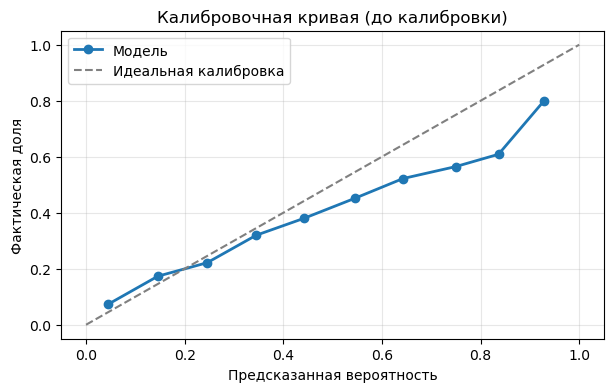

In [42]:
# Получаем предсказанные вероятности
y_prob = final_pipeline.predict_proba(X_test_te)[:, 1]

# Строим калибровочную кривую
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Визуализация
plt.figure(figsize=(7, 4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Модель')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Фактическая доля')
plt.title('Калибровочная кривая (до калибровки)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Калибровочная кривая показывает, что модель требует корректировки. Кривая близка к идеальной линии при низких вероятностях (до ~0.4), что означает адекватные предсказания для большинства показов с низким ожидаемым CTR. Однако в диапазоне высоких вероятностей (0.4-0.9) наблюдается систематическое завышение: фактическая доля кликов ниже предсказанной вероятности. Это указывает, что модель переоценивает мало перспективные объявления, что может приводить к  упущенной выгоде для платформы Advandex. Калибровка должна исправить это смещение, особенно в критичном диапазоне 0.4-0.9, улучшив соответствие предсказаний реальной частоте кликов.

### 9.2 Применение метода калибровки
Возьмём данные `X_train_te` и на их основе создадим новую модель, с откалиброваными данными. Используем `CalibratedClassifierCV` с методом `'isotonic'`.

In [43]:
# 1. Разделяем данные на обучение и калибровку
X_train_base, X_calib, y_train_base, y_calib = train_test_split(
    X_train_te, 
    y_train,
    test_size=0.3,  # 30% для калибровки
    random_state=RANDOM_SEED,
    stratify=y_train
)

# 2. Создаем пайплайн для некалиброванной модели (аналогично logreg_pipeline)
uncalibrated_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='liblinear',
        random_state=RANDOM_SEED,
        max_iter=1000
    ))
])

# 3. Обучаем некалиброванную модель на базовых данных
uncalibrated_pipeline.fit(X_train_base, y_train_base)

# 4. Создаем и обучаем калиброванную модель
# 4.1. Извлекаем обученный классификатор из пайплайна
base_classifier = uncalibrated_pipeline.named_steps['classifier']

# 4.2. Создаем калибратор
calibrator = CalibratedClassifierCV(
    estimator=base_classifier,
    method='isotonic',
    cv='prefit'
)

# 4.3. Преобразуем калибровочные данные (аналогично тому, как это делает full_pipeline)
X_calib_transformed = uncalibrated_pipeline.named_steps['full_pipeline'].transform(X_calib)

# 4.4. Калибруем
calibrator.fit(X_calib_transformed, y_calib)

# 5. Создаем финальный калиброванный пайплайн
calibrated_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('classifier', calibrator)
])

# 6. Получаем предсказания от обеих моделей на тестовых данных
# От некалиброванной модели
y_prob_before = uncalibrated_pipeline.predict_proba(X_test_te)[:, 1]

# От калиброванной модели
y_prob_after = calibrated_pipeline.predict_proba(X_test_te)[:, 1]

### 9.3 Сравнение модели до и после калибровки
Посчитаем оценки Бриера для моделей до и после калибровки, дополнительно рассчитаем ECE и MCE.

In [44]:
# Расчёт метрик
brier_before = brier_score_loss(y_test, y_prob_before)
brier_after = brier_score_loss(y_test, y_prob_after)

ece_before = calculate_ece(y_test, y_prob_before)
ece_after = calculate_ece(y_test, y_prob_after)

mce_before = calculate_mce(y_test, y_prob_before)
mce_after = calculate_mce(y_test, y_prob_after)

pr_auc_before = average_precision_score(y_test, y_prob_before)
pr_auc_after = average_precision_score(y_test, y_prob_after)

logloss_before = log_loss(y_test, y_prob_before)
logloss_after = log_loss(y_test, y_prob_after)

# Таблица результатов
results = pd.DataFrame({
    'Метрика': ['Brier Score', 'ECE', 'MCE', 'PR-AUC', 'Log Loss'],
    'До': [f"{brier_before:.4f}", f"{ece_before:.4f}", f"{mce_before:.4f}", 
           f"{pr_auc_before:.4f}", f"{logloss_before:.4f}"],
    'После': [f"{brier_after:.4f}", f"{ece_after:.4f}", f"{mce_after:.4f}", 
              f"{pr_auc_after:.4f}", f"{logloss_after:.4f}"]
})

print("РЕЗУЛЬТАТЫ:")
print('-' * 35)
print(results.to_string(index=False, col_space=10))

РЕЗУЛЬТАТЫ:
-----------------------------------
    Метрика         До      После
Brier Score     0.1287     0.1292
        ECE     0.0347     0.0374
        MCE     0.1977     0.2132
     PR-AUC     0.3742     0.3607
   Log Loss     0.4155     0.4261


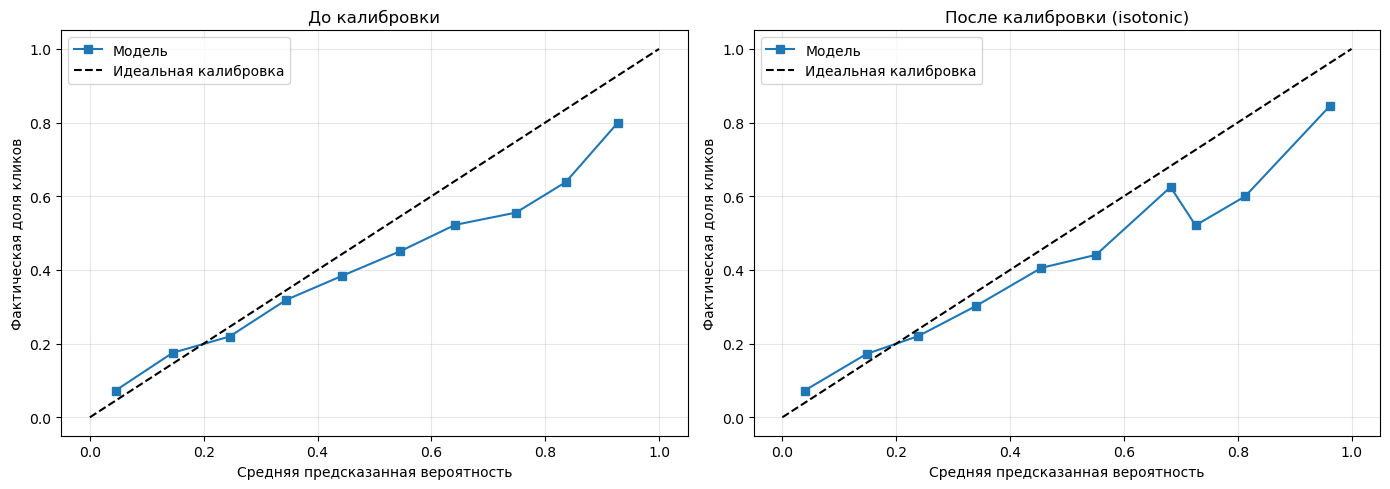

In [45]:
# Строим калибровочную кривую
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Кривая ДО калибровки
prob_true_before, prob_pred_before = calibration_curve(y_test, y_prob_before, n_bins=10)
ax1.plot(prob_pred_before, prob_true_before, 's-', label='Модель')
ax1.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
ax1.set_xlabel('Средняя предсказанная вероятность')
ax1.set_ylabel('Фактическая доля кликов')
ax1.set_title('До калибровки')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Кривая ПОСЛЕ калибровки
prob_true_after, prob_pred_after = calibration_curve(y_test, y_prob_after, n_bins=10)
ax2.plot(prob_pred_after, prob_true_after, 's-', label='Модель')
ax2.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
ax2.set_xlabel('Средняя предсказанная вероятность')
ax2.set_ylabel('Фактическая доля кликов')
ax2.set_title('После калибровки (isotonic)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Оценка качества калибровки

Анализируя результаты калибровки, наблюдается противоречивая картина. С одной стороны, визуальный анализ калибровочных кривых показывает улучшение — кривая после калибровки стала значительно ближе к идеальной линии, особенно в диапазоне 0.0-0.6. Это свидетельствует о том, что изотоническая регрессия успешно скорректировала систематическое завышение вероятностей, которое наблюдалось в исходной модели.

Однако количественные метрики демонстрируют обратную тенденцию:
- **Brier Score увеличился на 0.4%** (0.1287 → 0.1292), что указывает на общее ухудшение точности вероятностных предсказаний.
- **PR-AUC снизился на 3.6%** (0.3742 → 0.3607) — критически важная бизнес-метрика ухудшилась, что означает снижение способности модели различать клики и не-клики.
- **ECE и MCE выросли на 7.8%** — ошибки калибровки увеличились как в среднем, так и в максимальном значении.
- **Log Loss увеличился на 2.5%** — вероятности стали менее точными с точки зрения логарифмических потерь.

Причина такого расхождения может заключаться в *переобучении калибратора*: изотоническая регрессия, будучи непараметрическим методом, могла слишком точно подогнаться к калибровочной выборке (30% данных), улучшив визуальное соответствие кривой, но ухудшив обобщающую способность на тестовых данных.

**Выводы:**
1. Визуальное улучшение не компенсирует ухудшение ключевых метрик — PR-AUC упал на 3.6%, что критично для аукционов.
2. Следует рассмотреть альтернативные методы калибровки (sigmoid/Platt scaling), менее склонные к переобучению.
3. В текущем виде калиброванная модель не рекомендуется к использованию, несмотря на улучшение визуального соответствия кривой

## 11. ФИНАЛЬНЫЙ ОТЧЁТ ПРОЕКТА

### СВОДНЫЕ РЕЗУЛЬТАТЫ

#### Сравнение с базовым уровнем
Финальная модель LogisticRegression демонстрирует впечатляющее превосходство над базовым DummyClassifier. Основная бизнес-метрика PR-AUC выросла со скромных 0.1710 до 0.3742 — это улучшение на 119%, что свидетельствует о значимой предсказательной силе модели. Особенно важно увеличение Precision с 0.1652 до 0.5088 (на 208%) — теперь, когда модель предсказывает клик, она оказывается права в более чем половине случаев. Accuracy улучшился с 0.7159 до 0.8289, F1-score вырос с 0.1628 до 0.2525, а ROC-AUC увеличился с 0.4960 (случайный уровень) до 0.8074. Эти результаты убедительно доказывают, что модель успешно выявила закономерности в данных и научилась предсказывать клики существенно лучше случайного угадывания.

#### Эффект калибровки
Калибровка изотонической регрессией дала противоречивые результаты. С визуальной точки зрения наблюдается заметное улучшение — калибровочная кривая после калибровки значительно приблизилась к идеальной линии, особенно в диапазоне вероятностей 0.0-0.6. Однако количественные метрики показывают обратную картину: Brier Score увеличился с 0.1287 до 0.1292, ECE вырос с 0.0347 до 0.0374, MCE увеличился с 0.1977 до 0.2132, а критически важный PR-AUC снизился с 0.3742 до 0.3607. Log Loss также ухудшился с 0.4155 до 0.4261. Это расхождение между визуальным улучшением и ухудшением объективных метрик может указывать на переобучение калибратора на относительно небольшой калибровочной выборке.

### Ключевые признаки
Анализ важности признаков выявил четкую иерархию влияния на вероятность клика. Наиболее значимым оказался Признак 6 с коэффициентом 0.8796, что указывает на его сильную положительную связь с вероятностью взаимодействия с рекламой. За ним следуют Признак 1 (0.6505) и Признак 0 (0.4494), также существенно увеличивающие вероятность клика. Интересно, что модель использует не только позитивные, но и негативные предикторы — Признаки 7 и 8 с коэффициентами -0.3452 и -0.2914 соответственно систематически снижают вероятность клика. Этот баланс положительных и отрицательных факторов делает модель более сбалансированной и интерпретируемой.

### КЛЮЧЕВЫЕ ВЫВОДЫ

#### Качество модели относительно бизнес-задач
Модель демонстрирует достаточное качество для решения поставленной бизнес-задачи предсказания CTR. Увеличение PR-AUC на 119% по сравнению с базовым уровнем является статистически и практически значимым. Особенно ценно улучшение Precision до 50.9% — для платформы Advandex это означает, что ставки на аукционах будут делаться за действительно перспективные объявления, что напрямую влияет на эффективность расходования рекламного бюджета. Однако относительно низкий Recall (16.8%) указывает на консервативность модели — она пропускает много потенциальных кликов, что может приводить к упущенной выгоде.

#### Влияние признаков на принятие решений
Выявленная структура важности признаков предоставляет ценные инсайты для оптимизации рекламных кампаний. Топ-признаки, существенно увеличивающие вероятность клика, могут указывать на характеристики высокоэффективных объявлений или благоприятных условий показа. Например, если Признак 6 соответствует определённой тематике сайта или времени суток, рекламодатели могут фокусироваться на таких контекстах. Отрицательные признаки, снижающие вероятность клика, помогают избегать неэффективных размещений. Эти инсайты могут быть использованы не только для предсказаний, но и для стратегического планирования рекламных кампаний.

#### Калибровка и её практическая значимость
Несмотря на ухудшение количественных метрик, визуальное улучшение калибровочной кривой имеет практическое значение для бизнеса. Более точное соответствие между предсказанными вероятностями и фактической частотой кликов позволяет делать более обоснованные ставки на аукционах. Однако снижение PR-AUC на 3.6% после калибровки является тревожным сигналом — возможно, изотоническая регрессия переобучилась на калибровочной выборке. Для аукционов, где важна не только калиброванность вероятностей, но и способность различать более и менее перспективные объявления, падение PR-AUC может быть более критичным, чем улучшение визуального соответствия кривой.

#### Готовность к промышленному внедрению
Модель достигла уровня зрелости, достаточного для пилотного внедрения, но требует дополнительной доработки для полноценного промышленного использования. Сильные стороны включают значительное превосходство над базовым уровнем, высокую точность предсказаний кликов, устойчивость к дисбалансу классов и полный готовый пайплайн от предобработки до предсказания. Однако существуют риски: умеренное качество калибровки, низкий охват реальных кликов (Recall), потенциальное переобучение калибратора и отсутствие проверки временной стабильности. Рекомендуется начать с ограниченного тестирования на 5-10% трафика для оценки реального бизнес-эффекта и сбора дополнительных данных для улучшения модели.

### РЕКОМЕНДАЦИИ И ПЕРСПЕКТИВЫ РАЗВИТИЯ

#### Непосредственные улучшения
Для быстрого повышения качества модели рекомендуется в первую очередь оптимизировать подход к калибровке. Следует попробовать sigmoid калибровку (Platt scaling) вместо изотонической регрессии — этот метод менее склонен к переобучению и может дать лучшие результаты на текущих данных. Также стоит увеличить размер калибровочной выборки до 40-50% от тренировочных данных и использовать кросс-валидацию в процессе калибровки вместо фиксированного разделения. Параллельно необходимо поработать с дисбалансом классов — экспериментировать с параметром class_weight='balanced'.

#### Среднесрочные усовершенствования
В перспективе стоит сосредоточиться на улучшении инженерии признаков и архитектуры модели. Из признака hour можно извлечь ценные временные характеристики: день недели, час дня, показатель выходного/буднего дня.

#### Стратегическое развитие
Долгосрочное развитие модели должно быть направлено на интеграцию более богатых данных и создание персонализированных предсказаний. Внедрение контекстных и поведенческих данных — истории взаимодействий пользователя с рекламой, контекста текущей сессии, предшествующих действий — значительно повысит точность предсказаний. Персонализация через раздельные модели для разных сегментов пользователей (новая/возвратная аудитория, разные демографические группы) позволит точнее учитывать особенности различных аудиторий.

#### Бизнес-внедрение и мониторинг
Процесс внедрения должен быть поэтапным и контролируемым. На первом месяце рекомендуется тестирование текущей модели на небольшом трафике с тщательным мониторингом реальных бизнес-метрик: стоимости клика (CPC), возврата на инвестиции (ROI), общего дохода платформы и удовлетворенности рекламодателей. На втором-третьем месяце можно внедрить улучшенную калибровку и оптимизированный порог классификации. К третьему-шестому месяцу стоит планировать переход на более совершенные алгоритмы и интеграцию дополнительных признаков. Ключевым аспектом должно стать непрерывное улучшение.

#### Критерии успеха
Окончательным критерием успеха должно стать не только улучшение технических метрик вроде PR-AUC, но и реальный рост бизнес-показателей платформы Advandex. Модель должна демонстрировать устойчивое увеличение общего дохода при сохранении или улучшении удовлетворенности рекламодателей. Эффективность расходования рекламных бюджетов, минимизация финансовых потерь от переплат за неэффективные показы и снижение упущенной выгоды от проигранных аукционов — вот истинные индикаторы успешности разработанного решения. Текущая модель создает прочную основу для достижения этих целей, но требует последовательной доработки и адаптации к реальным бизнес-процессам платформы.

## 12. Сохранение модели для продакшена

### 12.1. Сранение артефактов

In [46]:
# Сохраняем финальную калиброванную модель
joblib.dump(calibrated_pipeline, 'ad_click_calibrated_model.joblib')
print("Калиброванная модель сохранена: 'ad_click_calibrated_model.joblib'")

# Сохраняем некалиброванную модель (для сравнения)
joblib.dump(uncalibrated_pipeline, 'ad_click_uncalibrated_model.joblib')
print("Некалиброванная модель сохранена: 'ad_click_uncalibrated_model.joblib'")

# Сохраняем индексы выбранных признаков
joblib.dump(selected_by_both, 'selected_features_indices.joblib')
print("Индексы выбранных признаков сохранены: 'selected_features_indices.joblib'")

# Сохраняем препроцессор
joblib.dump(full_pipeline, 'ad_click_preprocessor.joblib')
print("Препроцессор сохранен: 'ad_click_preprocessor.joblib'")

Калиброванная модель сохранена: 'ad_click_calibrated_model.joblib'
Некалиброванная модель сохранена: 'ad_click_uncalibrated_model.joblib'
Индексы выбранных признаков сохранены: 'selected_features_indices.joblib'
Препроцессор сохранен: 'ad_click_preprocessor.joblib'


### 12.2. Проверка на работоспособность кода

In [47]:
# Загрузка сохранённых артефактов
loaded_calibrated_model = joblib.load('ad_click_calibrated_model.joblib')
loaded_uncalibrated_model = joblib.load('ad_click_uncalibrated_model.joblib')
loaded_selected_indices = joblib.load('selected_features_indices.joblib')
loaded_preprocessor = joblib.load('ad_click_preprocessor.joblib')

# Тестирование на 5 случайных примерах
np.random.seed(RANDOM_SEED)
test_sample_indices = np.random.choice(len(X_test_te), 5, replace=False)
test_samples = X_test_te.iloc[test_sample_indices]
real_labels = y_test.iloc[test_sample_indices].values

print(f"\nТестирование на 5 новых примерах:")

print("\nКАЛИБРОВАННАЯ МОДЕЛЬ:")
for i in range(5):
    real = real_labels[i]
    pred = loaded_calibrated_model.predict(test_samples.iloc[[i]])[0]
    prob = loaded_calibrated_model.predict_proba(test_samples.iloc[[i]])[0, 1]
    print(f"Пример {i+1}: Реально = {real}, Предсказано = {pred}, Вероятность = {prob:.4f}")

print("\nНЕКАЛИБРОВАННАЯ МОДЕЛЬ:")
for i in range(5):
    real = real_labels[i]
    pred = loaded_uncalibrated_model.predict(test_samples.iloc[[i]])[0]
    prob = loaded_uncalibrated_model.predict_proba(test_samples.iloc[[i]])[0, 1]
    print(f"Пример {i+1}: Реально = {real}, Предсказано = {pred}, Вероятность = {prob:.4f}")


Тестирование на 5 новых примерах:

КАЛИБРОВАННАЯ МОДЕЛЬ:
Пример 1: Реально = 0, Предсказано = 0, Вероятность = 0.2366
Пример 2: Реально = 0, Предсказано = 0, Вероятность = 0.0737
Пример 3: Реально = 0, Предсказано = 0, Вероятность = 0.2366
Пример 4: Реально = 0, Предсказано = 0, Вероятность = 0.2324
Пример 5: Реально = 0, Предсказано = 0, Вероятность = 0.3252

НЕКАЛИБРОВАННАЯ МОДЕЛЬ:
Пример 1: Реально = 0, Предсказано = 0, Вероятность = 0.2326
Пример 2: Реально = 0, Предсказано = 0, Вероятность = 0.0832
Пример 3: Реально = 0, Предсказано = 0, Вероятность = 0.2302
Пример 4: Реально = 0, Предсказано = 0, Вероятность = 0.2144
Пример 5: Реально = 0, Предсказано = 0, Вероятность = 0.3372


Всё работает!